# **Processing the Linguistic data**
This uses the "OCSEAN_language_collection_overview_April_25.xlsx" data, CleanedFiles and CleanedFiles-v1.1 folders.

# Import modules

In [4]:
import pandas as pd 
import os 
from thefuzz import process
import seaborn as sns
import matplotlib.pyplot as plt
from lingpy import * # We're just importing everything from lingpy for simplicity
from lingpy.sequence.sound_classes import ipa2tokens
import re
import math
from datetime import datetime

In [5]:
os.chdir('/Users/dmsfr/OCSEAN @ Bristol/Process Linguist Data') # Setting new directory

# Load the Collection of Languages Data

In [7]:
collection_sheet = pd.read_excel("OCSEAN_language_collection_overview_April_25.xlsx")
#collection_sheet # View the data # Uncomment to show the data

# Add 'latitude' and 'longitude'

In [9]:
def parse_location(text):
    """Parse location coordinates from decimal degrees or DMS format."""
    # Handle NaN or non-string values
    if pd.isna(text) or not isinstance(text, str):
        return None, None
    
    # Check for decimal degrees format first
    decimal_match = re.match(r'\s*(-?\d+(?:\.\d+)?)\s*,\s*(-?\d+(?:\.\d+)?)\s*', text)
    if decimal_match:
        return float(decimal_match.group(1)), float(decimal_match.group(2))
    
    # Match DMS format and convert inline
    dms_regex = re.findall(r"(\d+)[°](\d+)'(\d+(?:\.\d+)?)\"?([NSEW])", text)
    if len(dms_regex) == 2:
        lat_data, lon_data = dms_regex
        
        # Convert DMS to decimal degrees inline
        lat = float(lat_data[0]) + float(lat_data[1])/60 + float(lat_data[2])/3600
        if lat_data[3] == 'S':
            lat *= -1
            
        lon = float(lon_data[0]) + float(lon_data[1])/60 + float(lon_data[2])/3600
        if lon_data[3] == 'W':
            lon *= -1
            
        return lat, lon
    
    return None, None  # Fallback if format doesn't match

In [10]:
# Apply parsing
collection_sheet[['latitude', 'longitude']] = collection_sheet['Google Map Coordinate'].apply(lambda x: pd.Series(parse_location(x)))

# Add a column 'Has_QC_File' and 'File_Source'
which determines if a language has been QC'd and the file folder where it is saved

In [12]:
# Initialize all tracking variables
languages_v11 = set()
languages_original = set()
collection = {}  # Stores DataFrames loaded from Excel files
colnames = {}    # Stores column names from each DataFrame
processed_languages = set()  # Track already processed languages

# Add columns to collection_sheet
collection_sheet["Has_QC_File"] = False
collection_sheet["File_Source"] = ""  # Track which folder the file came from

def get_file_path(file_name):
    """Helper function to determine file path and source"""
    if pd.isna(file_name) or file_name == "":
        return None, None
    
    # Check CleanedFiles-v1.1 first
    edited_path = os.path.join("CleanedFiles-v1.1", f"edited-{file_name}")
    if os.path.isfile(edited_path):
        return edited_path, "CleanedFiles-v1.1"
    
    # Check original CleanedFiles folder
    original_path = os.path.join("CleanedFiles", file_name)
    if os.path.isfile(original_path):
        return original_path, "CleanedFiles"
    
    return None, None

# Single loop to process all files
for id in collection_sheet.index:
    file_name = collection_sheet.at[id, "QC_FileName"]
    language = collection_sheet.at[id, "Language_BasedOnMasterSheet"]
    
    # Get file path and source
    file_path, source = get_file_path(file_name)
    
    if file_path is None:
        continue  # File doesn't exist, skip
    
    # Update collection_sheet with file existence info
    collection_sheet.at[id, "Has_QC_File"] = True
    collection_sheet.at[id, "File_Source"] = source
    
    # Track languages by source
    if not pd.isna(language):
        if source == "CleanedFiles-v1.1":
            languages_v11.add(language)
        else:  # source == "CleanedFiles"
            languages_original.add(language)
        
        # Load file only if language hasn't been processed yet
        if language not in processed_languages:
            try:
                collection[language] = pd.read_excel(file_path)
                colnames[language] = list(collection[language].columns.values)
                processed_languages.add(language)
                #print(f"Successfully loaded {language} from {source}")
            except Exception as e:
                print(f"Error reading {file_path}: {str(e)}")

# Create filtered dataframes
clean_sheet  = collection_sheet[collection_sheet["Has_QC_File"] == True]
broken_sheet = collection_sheet[collection_sheet["Has_QC_File"] == False]

# Generate language reports
languages_v11_list = sorted(list(languages_v11))
languages_original_list = sorted(list(languages_original))
all_languages = set(collection_sheet["Language_BasedOnMasterSheet"].dropna().unique())
languages_no_files = sorted(list(all_languages - languages_v11 - languages_original))

# Print results
print(f"Languages loaded from 'CleanedFiles-v1.1' (n = {len(languages_v11_list)}):")
print(", ".join(languages_v11_list) if languages_v11_list else "None")

print(f"\nLanguages loaded from 'CleanedFiles' (n = {len(languages_original_list)}):")
print(", ".join(languages_original_list) if languages_original_list else "None")

print(f"\nLanguages with no files loaded from either folder (n = {len(languages_no_files)}):")
print(", ".join(languages_no_files) if languages_no_files else "All languages have files loaded")

print(f"\nSummary:")
print(f"- Total files loaded: {len(collection)}")
print(f"- Files from CleanedFiles-v1.1: {sum(1 for lang in processed_languages if lang in languages_v11)}")
print(f"- Files from CleanedFiles: {sum(1 for lang in processed_languages if lang in languages_original and lang not in languages_v11)}")
print(f"- Rows with QC files: {len(clean_sheet)}")
print(f"- Rows without QC files: {len(broken_sheet)}")

Languages loaded from 'CleanedFiles-v1.1' (n = 54):
Abui Bunggeta, Abui Kilakawada, Abui Mobyetang, Agta, Agusan Manobo, Agutaynen, Akeanon, Arta, Ata, Ati, Balangao, Bali Aga, Batak, Boholano, Bolinao, Bontoc, Bulus, Cuyunon, Dela, Enggano, Hanunuo, Hiligaynon_20220813, Ibaloy/ Ibaloi, Ibanag, Ilognon (Hiligaynon), Inabaknon, Ivatan Isabtangan, Ivatan Itbayaten / Ivatan_Ichbayatan, Kamayo, Kankana-ey, Kapampangan, Kinaray-a, Kolibogan, Kusa, Loloan Malay, Manea, Manobo Tasaday, Meranao, Minamanwa, Obo Manobo, Pangasinan, Sabu Raijua, Sangil, Sinama Banguingui, Sinama Sitangkai, Sinama Tabawan, Sinurigaonon, Tagbanua Central, Talaandig (Binukid), Tausug, Tboli, Tuwali, Waray, Yakan

Languages loaded from 'CleanedFiles' (n = 25):
Abui Pelman, Adang, Alurung, Ba'a, Balinese, Bicolano, Buhid, Chabacano Caviteño , Gaddang, Hattang Kaye, Hiligaynon_20240802, Ilokano, Kalinga, Kelon, Klon, Kupang Malay, Mauta, Mawes Wares, Mawesdai, Molbog, Palawano, Reta Ternate, Sabu Seba, Tagakaulo, Uab M

You will notice discrepancies in the number of files loaded versus the number of languages in the 'collection_sheet' data. This is because there are 6 duplicate languages in the 'OCSEAN_language_collection_overview_April_25.xlsx' file.

# Add columns 'Has_IPA' and 'Has_English' to the languages that has QC
for languages having IPA and English columns, respectively

In [15]:
clean_sheet = clean_sheet.copy()
clean_sheet.loc[:, "Has_IPA"] = False                                # Assume all languages has no IPA
clean_sheet.loc[:, "Has_English"] = False                            # Assume all languages has no English language

# Initialize tracking sets for different combinations
languages_both = set()      # Languages with both IPA and English
languages_ipa_only = set()  # Languages with IPA only
languages_eng_only = set()  # Languages with English only
languages_neither = set()   # Languages with neither

for id in clean_sheet.index:
    langname = clean_sheet.at[id, "Language_BasedOnMasterSheet"]
    
    if pd.isna(langname) or langname not in colnames:                   # Skip language if NA or not in 'colnames' data above
        continue
        
    cols = colnames[langname]                                           # Get the list of column names for this specific language
    has_ipa = 'IPA' in cols
    has_english = 'English' in cols
    
    clean_sheet.loc[id, "Has_IPA"] = has_ipa                           # Replaces False by True if the term 'IPA' is found
    clean_sheet.loc[id, "Has_English"] = has_english                   # Replaces False by True if the term 'English' is found
    
    # Categorize languages based on what columns they have
    if has_ipa and has_english:
        languages_both.add(langname)
    elif has_ipa and not has_english:
        languages_ipa_only.add(langname)
    elif not has_ipa and has_english:
        languages_eng_only.add(langname)
    else:
        languages_neither.add(langname)

# Create separated dataframes for languages that has English and has no English
has_english_sheet = clean_sheet[clean_sheet["Has_English"] == True]    # With English
no_english_sheet  = clean_sheet[clean_sheet["Has_English"] == False]   # Without English

# Convert sets to sorted lists
languages_both_list = sorted(list(languages_both))
languages_ipa_only_list = sorted(list(languages_ipa_only))
languages_eng_only_list = sorted(list(languages_eng_only))
languages_neither_list = sorted(list(languages_neither))

# Print results
print(f"Languages with IPA and English (n = {len(languages_both_list)}):")
print(", ".join(languages_both_list) if languages_both_list else "None")

print(f"\nLanguages with IPA only (n = {len(languages_ipa_only_list)}):")
print(", ".join(languages_ipa_only_list) if languages_ipa_only_list else "None")

print(f"\nLanguages with English only (n = {len(languages_eng_only_list)}):")
print(", ".join(languages_eng_only_list) if languages_eng_only_list else "None")

print(f"\nLanguages with neither IPA nor English (n = {len(languages_neither_list)}):")
print(", ".join(languages_neither_list) if languages_neither_list else "None")

print(f"\nSummary:")
print(f"- Total languages processed: {len(languages_both) + len(languages_ipa_only) + len(languages_eng_only) + len(languages_neither)}")
print(f"- Languages with IPA column: {len(languages_both) + len(languages_ipa_only)}")
print(f"- Languages with English column: {len(languages_both) + len(languages_eng_only)}")

Languages with IPA and English (n = 12):
Abui Bunggeta, Ba'a, Enggano, Hiligaynon_20220813, Ibaloy/ Ibaloi, Ivatan Isabtangan, Ivatan Itbayaten / Ivatan_Ichbayatan, Mawesdai, Sabu Seba, Sinurigaonon, Tagakaulo, Tuwali

Languages with IPA only (n = 1):
Ibanag

Languages with English only (n = 59):
Abui Mobyetang, Abui Pelman, Agta, Agusan Manobo, Agutaynen, Akeanon, Arta, Ata, Ati, Balangao, Bali Aga, Balinese, Batak, Bicolano, Boholano, Bolinao, Bontoc, Buhid, Bulus, Chabacano Caviteño , Cuyunon, Dela, Gaddang, Hanunuo, Hattang Kaye, Hiligaynon_20240802, Ilognon (Hiligaynon), Ilokano, Inabaknon, Kalinga, Kamayo, Kankana-ey, Kapampangan, Kinaray-a, Kolibogan, Kupang Malay, Kusa, Loloan Malay, Manea, Manobo Tasaday, Mawes Wares, Meranao, Minamanwa, Molbog, Obo Manobo, Palawano, Pangasinan, Sabu Raijua, Sangil, Sinama Banguingui, Sinama Sitangkai, Sinama Tabawan, Tagbanua Central, Talaandig (Binukid), Tausug, Tboli, Uab Meto, Waray, Yakan

Languages with neither IPA nor English (n = 7):
A

# Here's the revised collection_sheet, now containing the 'Has_QC_File,' 'File_Source,' 'Has_IPA,' and 'Has_English' columns
and export to Excel for safekeeping

In [17]:
clean_sheet.to_excel("OCSEAN_collection_sheet_new.xlsx")
clean_sheet

,Language_BasedOnMasterSheet,ISO code (from Original_FileName),COUNTRY,LocalWordsPresent,QC_done,AddedToTheUnitedLanguagesMasterFile,Comment,Separator,Mismatches_Eng,Mismatches_IndoOrTaga,Original_FileName,QC_FileName,Google Map Coordinate,latitude,longitude,Has_QC_File,File_Source,Has_IPA,Has_English
0,Abui Bunggeta,ABZ,Indonesia,604.0,Yes,Yes,Some English and or Indonesian words in this l...,", and ; and ~ (?). Only used , and ;",41.0,87.0,OCSEAN-ABZ_20240605-BUNGGETA_WORDLIST.xlsx,OCSEAN-ABZ_20240605-BUNGGETA_WORDLIST_PostQC.xlsx,NaN,NaN,NaN,True,CleanedFiles-v1.1,True,True
1,Abui Kilakawada,ABZ,Indonesia,604.0,Yes,Yes,English and English Elicitation notes complete...,", and ; and ~ (?). Only used , and ;",41.0,87.0,OCSEAN-ABZ_20240606-KILAKAWADA_WORDLIST.xlsx,OCSEAN-ABZ_20240606-KILAKAWADA_WORDLIST_PostQC...,NaN,NaN,NaN,True,CleanedFiles-v1.1,False,False
2,Abui Mobyetang,ABZ,Indonesia,602.0,Yes,Yes,English Elicitation = English actually. Some E...,", and ; and ~ (?). Only used , and ;",41.0,87.0,OCSEAN-ABZ_20240610-MOBYETANG_WORDLIST.xlsx,OCSEAN-ABZ_20240610-MOBYETANG_WORDLIST_PostQC....,NaN,NaN,NaN,True,CleanedFiles-v1.1,False,True
3,Abui Pelman,ABZ,Indonesia,602.0,Yes,Yes,English Elicitation = English actually. Some E...,", and ; and ~ (?). Only used , and ;",41.0,87.0,OCSEAN-ABZ_20240610-PELMAN_WORDLIST.xlsx,OCSEAN-ABZ_20240610-PELMAN_WORDLIST_PostQC.xlsx,NaN,NaN,NaN,True,CleanedFiles,False,True
7,Adang,ADN,Indonesia,234.0,Yes,Yes,The formatting of indonesian words in this lan...,",",NaN,67.0,OCSEAN-ADN_20230427-WORDLIST.xlsx,OCSEAN-ADN_20230427-WORDLIST_PostQC.xlsx,NaN,NaN,NaN,True,CleanedFiles,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,Tboli,TBL,the Phillipines,1144.0,Yes,Not yet,"Two columns available - ""Tboli"" and ""Tboli - L...","/ and , (and possibly space?)",0.0,13.0,OCSEAN-TBL_20240802-WORDLIST.xlsx,OCSEAN-TBL_20240802-WORDLIST_PostQC.xlsx,"6.2093, 124.8432",6.209300,124.843200,True,CleanedFiles-v1.1,False,True
115,Tuwali,IFK,the Phillipines,691.0,Yes,Yes,I used wordlist2 because it had 3-4x more word...,Space? Should be rechecked by someone. Did not...,1.0,3.0,OCSEAN-IFK_20220715-WORDLIST2_1TO1228.xlsx,OCSEAN-IFK_20220715-WORDLIST2_1TO1228_PostQC.xlsx,NaN,NaN,NaN,True,CleanedFiles-v1.1,True,True
116,Uab Meto,AOZ,Indonesia,991.0,Yes,Yes,English/Indonesian seems to be identical to re...,/,0.0,0.0,AOZ_20220715-WORDLIST.xlsx,AOZ_20220715-WORDLIST_PostQC.xlsx,NaN,NaN,NaN,True,CleanedFiles,False,True
119,Waray,WAR,the Phillipines,1178.0,Yes,Not yet,"English Tagalog available, no Indonesian. No s...",space? Didn’t separate,0.0,1.0,OCSEAN-WAR_20240407-WORDLIST_1TO1228.xlsx,OCSEAN-WAR_20240407-WORDLIST_1TO1228_PostQC.xlsx,"12.312908225545875, 125.01703265863979",12.312908,125.017033,True,CleanedFiles-v1.1,False,True


# Extracting information about columns
In the 'Add a column 'Has_QC_File' and 'File_Source'' section above, we stored all of the column names of the 'collection' dictionary of all Excel files.

The goal of the code below is to check

In [19]:
from collections import Counter

all_cols = [col for sublist in colnames.values() for col in sublist]
counter = Counter(all_cols)
for item, count in counter.items():
    if count > 1:
        print(f"{item}: {count}")

English: 71
Indonesian: 36
IPA: 13
Semantic Sphere: 4
Tagalog: 56
ENGLISH ELICITATION NOTES: 7
CEBUANO: 5
Kamayo: 2
Talaandig: 2
Semantic_Field: 23
English elicitation notes: 20
Indonesian elicitation notes: 16
Cebuano: 14
Tagalog Elicitation Notes: 3
Ontology: 3
Ilocano: 11
Local Orthography: 3
Comment: 2
Hiligaynon: 2
NO.: 2
Kelon: 2
Sangil: 2


# Merging datasets
using the data that has English

In [21]:
# Fix the copy warning by making has_english_sheet independent
has_english_sheet = has_english_sheet.copy()

# Step 1: Find actual language column names using fuzzy matching (vectorized)
# Apply fuzzy matching to all rows at once instead of looping
has_english_sheet["Language_AsInFile"] = has_english_sheet["Language_BasedOnMasterSheet"].apply(
    lambda lang: process.extractOne(lang, colnames[lang])[0]
)

# Step 2: Create standardized DataFrames and combine in one step
# Use dictionary comprehension to replace the entire loop
joinable_collection = {
    # For each row, create a standardized DataFrame
    row["Language_BasedOnMasterSheet"]: (
        collection[row["Language_BasedOnMasterSheet"]]  # Get the original DataFrame
        [["English", row["Language_AsInFile"]]]         # Select only needed columns
        .rename(columns={                               # Rename to standard names
            "English": "Concept", 
            row["Language_AsInFile"]: "Word"
        })
        .assign(Language=row["Language_AsInFile"])      # Add Language column
        .dropna()                                       # Remove missing values
    )
    # Apply this to each row in has_english_sheet
    for _, row in has_english_sheet.iterrows()
}

# Step 3: Combine all languages into one dataset
# Stack all DataFrames vertically with continuous indexing
joined_data = pd.concat(joinable_collection.values(), axis=0, ignore_index=True).drop_duplicates()

# Convert 'Concept' and 'Word' columns to lowercase
joined_data['Concept'] = joined_data['Concept'].str.lower()
joined_data['Word'] = joined_data['Word'].str.lower()

In [22]:
joined_data

,Concept,Word,Language
0,sun,wariy,Abui_Bunggeta
1,moon,'uya,Abui_Bunggeta
2,star,furiy,Abui_Bunggeta
3,sky,'adiiy,Abui_Bunggeta
4,earth,buku; bukuw,Abui_Bunggeta
...,...,...,...
73627,imam,imam,Yakan
73628,bless,ridjiki,Yakan
73629,redeem,tawbat,Yakan
73630,curse,nukna',Yakan


# Rare Concepts Detection
using the 'OCSEAN_rareconcepts_matching.xlsx' file that was last modified on June 13, 2025. Stored in 'joined_data_updated' variable.

In [24]:
# Create a DataFrame to store results
matched_concepts = []

concept_counts = joined_data["Concept"].value_counts()
common_concepts=concept_counts[concept_counts>=25].index.tolist()
rare_concepts=concept_counts[concept_counts<25].index.tolist()

# For each rare concept, find the best match from common_concepts
for concept in rare_concepts:
    best_match, score = process.extractOne(concept, common_concepts)
    top_matches = process.extract(concept, common_concepts, limit=5)
    matched_concepts.append({
        'rare_concept': concept,
        'count': concept_counts[concept],
        'best_match': best_match,
        'similarity_score': score,
        'languages':",".join(list(joined_data['Language'][joined_data['Concept']==concept])),
        'top_matches':",".join([x[0] for x in top_matches])
    })

# Convert to DataFrame for display
matched_df = pd.DataFrame(matched_concepts)

matched_df.to_excel("OCSEAN_rareconcepts_matching.xlsx")

# Show the result
matched_df

,rare_concept,count,best_match,similarity_score,languages,top_matches
0,mound of stones for ritual activities,22,stone,90,"Abui_Bunggeta,Abui_Bunggeta,Abui_Mobyetang,Abu...","stone,in front of,look for, seek,palm of hand,..."
1,casuarina tree,22,tree,90,"Agusan_Manobo,Arta,Ba_a,Balinese,Bicolano,Boho...","tree,three,eye,see,urine"
2,"jew's harp, mouth harp",22,mouth,90,"Agusan_Manobo,Arta,Ata,Ba_a,Balinese,Bicolano,...","mouth,adam's apple,sharp,hair,hear"
3,"gum tree, eucalyptus",20,tree,90,"Agusan_Manobo,Arta,Ba_a,Balinese,Boholano,Buhi...","tree,bark (of tree),moringa tree,banyan tree,gums"
4,black nightshade,19,black,90,"Agusan_Manobo,Agutaynen,Arta,Ba_a,Balinese,Bat...","black,night,shade,die,fight"
...,...,...,...,...,...,...
1396,truth,1,"dust, fine earth",68,Loloan_Malay,"dust, fine earth,placenta, afterbirth,run,cut,..."
1397,about,1,cut,72,Loloan_Malay,"cut,call out,butterfly,buttocks,tight, taut"
1398,yard/page,1,year,77,Loloan_Malay,"year,red,pay,eagle,guard"
1399,delicate,1,cat,90,Loloan_Malay,"cat,at,defecate,die,ten"


Above are concepts that are considered to be 'rare.' Although the definition of rarity is frivolous in nature. We set it to be less than 25, i.e., if the concept only appears less than 25 times in all the 70,000+ concepts, then it is considered a rare concept.

# Rare Concept Correction
using the 'OCSEAN_rareconcepts_matching.xlsx' file that was last modified on June 13, 2025. Stored in 'joined_data_updated' variable.

In [27]:
# Copy the rare concepts
matching_df = pd.read_excel("OCSEAN_rareconcepts_matching_correction.xlsx")

# Display the structure of the matching file for verification
print("Matching file structure:")
#print(matching_df.head())
print(f"Shape: {matching_df.shape}")
#print("\nColumns:", matching_df.columns.tolist())

print("\nJoined data structure:")
print(joined_data.head())
print(f"Shape: {joined_data.shape}")

# Create a mapping dictionary from the Excel file
# Only include rows where 'best_match' is not empty/null
mapping_dict = {}

for idx, row in matching_df.iterrows():
    rare_concept = row['rare_concept']
    best_match = row['best_match']
    
    # Check if best_match is not empty/null
    if pd.notna(best_match) and str(best_match).strip() != '':
        mapping_dict[rare_concept] = best_match
        #print(f"Mapping: '{rare_concept}' -> '{best_match}'")

print(f"\nTotal unique replacements made: {len(mapping_dict)}")

# Apply the replacement to the joined_data
# Create a copy to preserve the original data
joined_data_updated = joined_data.copy()

# Track changes for reporting
changes_made = 0
original_concepts = []
new_concepts = []

for idx, row in joined_data_updated.iterrows():
    current_concept = row['Concept']
    
    # Check if current concept should be replaced
    if current_concept in mapping_dict:
        new_concept = mapping_dict[current_concept]
        joined_data_updated.at[idx, 'Concept'] = new_concept
        
        # Track the change
        changes_made += 1
        original_concepts.append(current_concept)
        new_concepts.append(new_concept)
        
        #print(f"Row {idx}: Changed '{current_concept}' to '{new_concept}'")

# Summary of changes
print(f"\n=== SUMMARY ===")
print(f"Total rows processed: {len(joined_data)}")
print(f"Total changes made: {changes_made}")

if changes_made > 0:
    print("\nChanges made:")
    for i in range(min(10, len(original_concepts))):  # Show first 10 changes
        print(f"  '{original_concepts[i]}' -> '{new_concepts[i]}'")
    
    if changes_made > 10:
        print(f"  ... and {changes_made - 10} more changes")

Matching file structure:
Shape: (1391, 7)

Joined data structure:
  Concept         Word       Language
0     sun        wariy  Abui_Bunggeta
1    moon         'uya  Abui_Bunggeta
2    star        furiy  Abui_Bunggeta
3     sky       'adiiy  Abui_Bunggeta
4   earth  buku; bukuw  Abui_Bunggeta
Shape: (73439, 3)

Total unique replacements made: 620

=== SUMMARY ===
Total rows processed: 73439
Total changes made: 1390

Changes made:
  'dust' -> 'dust, fine earth'
  'dawn' -> 'twilight, dawn'
  'dawn' -> 'twilight, dawn'
  'road, path' -> 'road'
  'sail (v.)' -> 'sail'
  'sail (v.)' -> 'sail'
  'castnet' -> 'fishnet'
  'thatch for making rooves' -> 'thatch, reed or grass used for making roofs'
  'thatch for making rooves' -> 'thatch, reed or grass used for making roofs'
  'roof rafter (lengthwise)' -> 'rafter'
  ... and 1380 more changes


You'll notice that the **'Total unique replacements made'** is not the same as the **'Total changes made.'** This is because there are **duplicate concepts** which has been counted as separate in the 'Total changes made' count.

# Here's the data that will be used later on for lingpy data preprocessing and analysis

In [30]:
joined_data_updated

,Concept,Word,Language
0,sun,wariy,Abui_Bunggeta
1,moon,'uya,Abui_Bunggeta
2,star,furiy,Abui_Bunggeta
3,sky,'adiiy,Abui_Bunggeta
4,earth,buku; bukuw,Abui_Bunggeta
...,...,...,...
73627,imam,imam,Yakan
73628,bless,ridjiki,Yakan
73629,redeem,tawbat,Yakan
73630,curse,nukna',Yakan


In [31]:
# Early export to Excel, for checking only, not included in final
#joined_data_updated.to_excel("joineddata_for_checking.xlsx")

# Number of Languages per Concept and Number of Concepts per Language

In [33]:
concept_counts  = joined_data_updated["Concept"].value_counts()
language_counts = joined_data_updated["Language"].value_counts()

In [34]:
concept_counts

Concept
smell               196
fly                 133
short               113
bathe               113
child               103
                   ... 
petals                1
out                   1
family/relatives      1
everywhere            1
isnʔt that so?        1
Name: count, Length: 2016, dtype: int64

In [35]:
language_counts

Language
Kankana_ey             1731
Bulus                  1694
Cuyunon                1413
Bicolano               1370
Ilognon                1314
                       ... 
Hiligaynon_20240802     460
Sangil                  200
Bali_Aga                197
Kupang Malay            142
Sabu_Seba               100
Name: count, Length: 71, dtype: int64

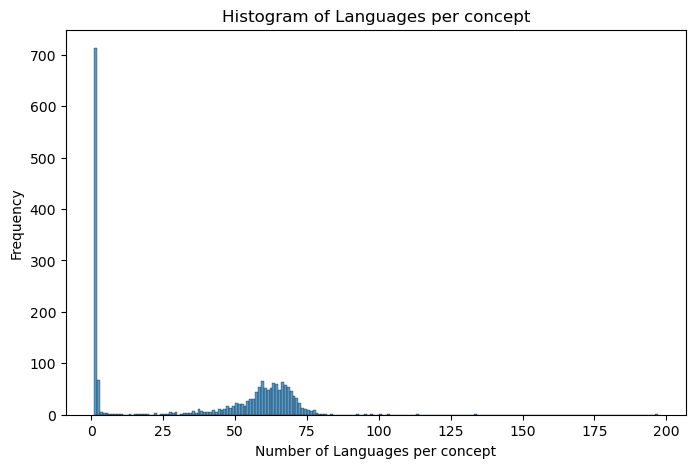

In [36]:
plt.figure(figsize=(8, 5))
sns.histplot(concept_counts, bins=range(concept_counts.min(), concept_counts.max() + 2), kde=False, edgecolor='black')
plt.xlabel('Number of Languages per concept')
plt.ylabel('Frequency')
plt.title('Histogram of Languages per concept')
plt.show()

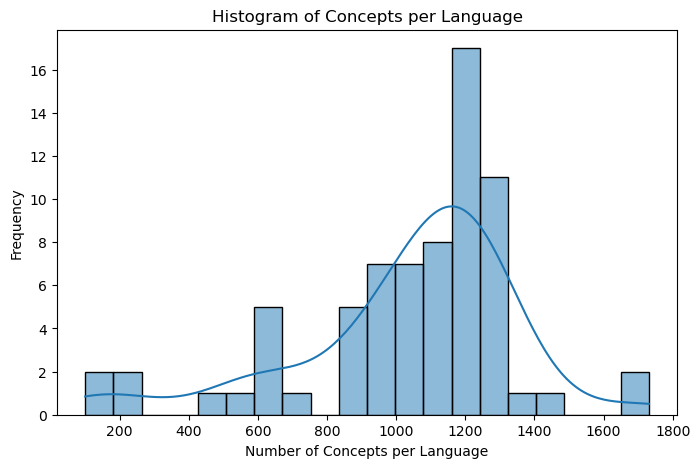

In [37]:
plt.figure(figsize=(8, 5))
sns.histplot(language_counts, bins=20, kde=True, edgecolor='black')
plt.xlabel('Number of Concepts per Language')
plt.ylabel('Frequency')
plt.title('Histogram of Concepts per Language')
plt.show()

# Converting 'Long' to 'Wide' data

In [39]:
joined_data_updated_wide = (joined_data_updated.drop_duplicates(['Concept', 'Language'])  # Remove duplicates first in 'Concept' and 'Language' subset of data
                                   .pivot_table(index='Concept',              # Rows: concepts
                                               columns='Language',             # Columns: languages
                                               values='Word',                  # Values: words
                                               aggfunc='first',                # Take first value (redundant after dedup)
                                               fill_value=None)               # Fill missing with None
                                   .drop_duplicates()                         # Drop duplicate rows
                                   .dropna(axis=0, how='all')                 # Drop rows where all values are NaN
                                   .dropna(axis=1, how='all'))                # Drop columns where all values are NaN

In [40]:
# View the data
joined_data_updated_wide # Uncomment to show data

Language,Abui_Bunggeta,Abui_Mobyetang,Abui_Pelman,Agta,Agusan_Manobo,Agutaynen,Akeanon,Arta,Ata,Ati,...,Sinurigaonon,Tagakaulo,Tagbanwa_Central,Talaandig,Tausug,Tboli,Tuwali,Uab_Meto,Waray,Yakan
Concept,,,,,,,,,,,,,,,,,,,,,
(coral) reef,koqai,tama kokai,tama kokai,NaN,bahura,NaN,takut,karagtan bunba,NaN,NaN,...,pisangan,NaN,ngirito tangkapa,NaN,NaN,botu lemnek,NaN,laut,daramo utango,sahasa'
160 couplets,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1pl excl,niidi,niedi,niedi ~ niadi,kami,sikami,yami,kami,tami,kanami,ikam,...,kami,kami,kami,sikuy,kami,olon béle tekuy,ditaku,hai',kami,kami
1pl incl,piidi,piedi,piadi,siketam,kita,eta,kita,dita at,kanta,kiti'e,...,kita,kitadun,tami,sikay,kita,tekuy,ditaku,hit,kita,kitebi
1sg,needi,needi,needi,saken,siak,yo,ako,tan,kudi,ako',...,ako,aku,ako,yan-a,aku,ou,haon,au',ak,aku
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
youngest child,NaN,NaN,NaN,gipo,giposan,are,kamanghuran,nariludahana neditul,kalitan,kinagot,...,diposi,mangud,kiya’pusan,tinangkedan,siyali,son twoli,naudi,‘heot susu,puto,anak siyali
your highness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
your permission,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Export to Excel

In [42]:
# Replace 'True' to 'TRUE' since Excel accepts capital letters for boolean data
has_english_sheet.replace({True: 'TRUE', False: 'FALSE'}).to_excel("OCSEAN_initial_englishsheet.xlsx")  
collection_sheet.replace({True: 'TRUE', False: 'FALSE'}).to_excel("OCSEAN_initial_collectionsheet.xlsx")

In [43]:
joined_data_updated.to_excel("OCSEAN_initial_joineddata.xlsx")
joined_data_updated.to_csv("OCSEAN_initial_joineddata.tsv", sep='\t', index=False)
joined_data_updated_wide.to_excel("OCSEAN_initial_joineddata_pivoted_derived.xlsx")

# on lingpy

In [4]:
# Uncomment any in case a module is not yet installed
#!pip install eng-to-ipa==0.0.2
#!pip install pandas==2.2.2
#!pip install lingpy==2.6.13
#!pip install datetime==5.5

# Load data
Load first in 'CleanedFiles-v1.1' and if the file is not existent, then load from 'CleanedFiles'

In [47]:
od = pd.read_table('OCSEAN_initial_joineddata.tsv')
od = od[['Concept','Word','Language']] # Specifying columns also recorders them in the dataframe
od = od.dropna() # Remove if there were NaN's
od = od.drop_duplicates() # Remove if there were duplicates

# Here's the data
od

,Concept,Word,Language
0,sun,wariy,Abui_Bunggeta
1,moon,'uya,Abui_Bunggeta
2,star,furiy,Abui_Bunggeta
3,sky,'adiiy,Abui_Bunggeta
4,earth,buku; bukuw,Abui_Bunggeta
...,...,...,...
73434,imam,imam,Yakan
73435,bless,ridjiki,Yakan
73436,redeem,tawbat,Yakan
73437,curse,nukna',Yakan


# Split into Multiple Rows if a 'form' has delimiters such as , and ; and / and ~

This is in the case when there are forms that have 1 form but has multiple concepts. We make separate rows of each. 

Example:

- Concept | Form
- cave    | yungib,kuweba

Will become 2 rows

- cave | yungib
- cave | kuweba

In [49]:
# Clean and optionally split into Multiple Rows if a 'form' has delimiters such as , and ; and / and ~
def clean_and_split_forms(df, column_name='Word', delimiters='default', split_on_delimiters=True, 
                          verbose=True, normalize_spaces=True, remove_tabs=True, remove_newlines=True, 
                          remove_carriage_returns=True, remove_non_breaking_spaces=True,
                          export_excel=False, filename='data_processing_results'):
    """
    Clean and optionally split a DataFrame column containing delimited text.
    
    Args:
        df (pd.DataFrame): Input DataFrame
        column_name (str): Name of column to process
        delimiters (list): List of delimiters to replace with commas. 
                          Defaults to [';', '/', '~']
        split_on_delimiters (bool): If True, splits on delimiters and creates multiple rows.
                                   If False, only performs cleaning operations.
        verbose (bool): Whether to print progress information
        normalize_spaces (bool): If True, replaces multiple consecutive spaces with single spaces
        remove_tabs (bool): If True, removes tab characters (\t)
        remove_newlines (bool): If True, removes newline characters (\n)
        remove_carriage_returns (bool): If True, removes carriage return characters (\r)
        remove_non_breaking_spaces (bool): If True, removes non-breaking spaces (\xa0)
        export_excel (bool): If True, exports processing stages to Excel file
        filename (str): Base filename for Excel export (timestamp will be added)
    
    Returns:
        pd.DataFrame: Processed DataFrame with cleaned and optionally split forms
    """
    if delimiters == 'default':
        delimiters = [';', '/', '~']#, '|', '\\', '&']
    
    # Store original data for export
    original_data = df.copy()
    
    # Create a copy to avoid modifying original
    result_df = df.copy()
    
    if verbose:
        print(f'Original number of rows: {len(original_data)}')
        if split_on_delimiters:
            print('Mode: Cleaning and splitting on delimiters')
        else:
            print('Mode: Cleaning only (no delimiter splitting)')
    
    # 1. First, clean whitespace characters before processing
    if remove_tabs:
        result_df[column_name] = result_df[column_name].str.replace('\t', ' ', regex=False)
    if remove_newlines:
        result_df[column_name] = result_df[column_name].str.replace('\n', ' ', regex=False)
    if remove_carriage_returns:
        result_df[column_name] = result_df[column_name].str.replace('\r', ' ', regex=False)
    if remove_non_breaking_spaces:
        result_df[column_name] = result_df[column_name].str.replace('\xa0', ' ', regex=False)
    
    # Normalize multiple spaces to single spaces
    if normalize_spaces:
        result_df[column_name] = result_df[column_name].str.replace(r'\s+', ' ', regex=True)
    
    # 2. Strip any leading/trailing whitespace after normalization
    result_df[column_name] = result_df[column_name].str.strip()
    
    # 3. Handle delimiter processing based on mode
    if split_on_delimiters:
        # Normalize delimiters - replace all with commas
        for delimiter in delimiters:
            result_df[column_name] = result_df[column_name].str.replace(delimiter, ',', regex=False)
        
        # Clean up multiple consecutive commas and normalize whitespace around commas
        result_df[column_name] = result_df[column_name].str.replace(r',+', ',', regex=True)  # Multiple commas -> single comma
        result_df[column_name] = result_df[column_name].str.replace(r'\s*,\s*', ',', regex=True)  # Remove spaces around commas
        result_df[column_name] = result_df[column_name].str.strip(',')  # Remove leading/trailing commas
        
        # Split by comma and explode
        result_df[column_name] = result_df[column_name].str.split(',')
        exploded_data = result_df.explode(column_name).copy()  # Store exploded data for export
        result_df = result_df.explode(column_name)
        
        # Clean up the split results
        result_df[column_name] = result_df[column_name].str.strip()  # Remove whitespace
    else:
        # For cleaning-only mode, create exploded_data as a copy for consistency in export
        exploded_data = result_df.copy()
    
    # 4. Store data before removals for tracking
    before_removal = result_df.copy()
    before_removal_count = len(before_removal)
    
    # 5. Remove invalid entries (NaN and empty strings)
    result_df = result_df[result_df[column_name].notna()]  # Remove NaN
    result_df = result_df[result_df[column_name] != '']    # Remove empty strings
    after_invalid_removal_count = len(result_df)
    
    # 6. Remove duplicates 
    cleaned_data = result_df.drop_duplicates()
    after_duplicate_removal_count = len(cleaned_data)
    
    # 7. Calculate removed data by tracking each removal step
    # Find invalid entries that were removed
    invalid_removed = before_removal[
        (before_removal[column_name].isna()) | 
        (before_removal[column_name] == '')
    ].copy()
    
    # Find duplicates that were removed
    valid_data = before_removal[
        (before_removal[column_name].notna()) & 
        (before_removal[column_name] != '')
    ].copy()
    
    # Get duplicates by finding rows that appear more than once
    duplicated_mask = valid_data.duplicated(keep='first')
    duplicates_removed = valid_data[duplicated_mask].copy()
    
    # Combine all removed data
    removed_data = pd.concat([invalid_removed, duplicates_removed], ignore_index=True)
    
    # Reset index for cleaned data
    cleaned_data = cleaned_data.reset_index(drop=True)
    
    # 8. Add sequential ID to cleaned data
    cleaned_data['ID'] = range(len(cleaned_data))
    cleaned_data.set_index('ID', inplace=True)
    
    if verbose:
        print(f'Final number of rows: {cleaned_data.shape[0]}')
        if split_on_delimiters:
            print(f'Rows change: {cleaned_data.shape[0] - original_data.shape[0]} (net effect of splitting and cleaning)')
        print(f'Invalid entries removed (NA or empty): {len(invalid_removed)}')
        print(f'Duplicates removed: {len(duplicates_removed)}')
        print(f'Total rows removed during processing: {len(removed_data)}')
    
    # 9. Export to Excel if requested
    if export_excel:
        from datetime import datetime
        # Generate timestamp in the format: MonthDayYear24HourTimeFormat
        timestamp = datetime.now().strftime('%m%d%Y_%H%M%S')
        excel_filename = f"{filename}_{timestamp}.xlsx"
        
        with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
            original_data.to_excel(writer, sheet_name='Original data', index=True)
            if split_on_delimiters:
                exploded_data.to_excel(writer, sheet_name='Exploded data', index=True)
            else:
                exploded_data.to_excel(writer, sheet_name='Cleaned data (pre-dedup)', index=True)
            removed_data.to_excel(writer, sheet_name='Removed data', index=False)
            cleaned_data.to_excel(writer, sheet_name='Final cleaned data', index=True)
        
        if verbose:
            print(f'Excel file exported: {excel_filename}')
    
    return cleaned_data


# Example usage:
# For splitting on delimiters (original behavior):
# result = clean_and_split_forms(df, column_name='Word', split_on_delimiters=True)

# For cleaning only (no delimiter splitting):
# result = clean_and_split_forms(df, column_name='Word', split_on_delimiters=False)

In [50]:
od_exploded = clean_and_split_forms(
    df=od, 
    column_name='Word', 
    delimiters='default', 
    split_on_delimiters=True,
    verbose=True, 
    export_excel=False,                # Can take some time exporting to Excel
    filename='data_processing_results' # Will only be used when export_excel=True
)

Original number of rows: 73438
Mode: Cleaning and splitting on delimiters
Final number of rows: 73858
Rows change: 420 (net effect of splitting and cleaning)
Invalid entries removed (NA or empty): 2
Duplicates removed: 2
Total rows removed during processing: 4


In [51]:
od_exploded_Concept = clean_and_split_forms(
    df=od_exploded,
    column_name='Concept', 
    delimiters='default', 
    split_on_delimiters=False,
    verbose=True, 
    export_excel=False,                # Can take some time exporting to Excel
    filename='data_processing_results' # Will only be used when export_excel=True
)

#od_exploded_Concept # Uncmomment to view

Original number of rows: 73858
Mode: Cleaning only (no delimiter splitting)
Final number of rows: 73857
Invalid entries removed (NA or empty): 0
Duplicates removed: 1
Total rows removed during processing: 1


In [52]:
od_exploded_Language = clean_and_split_forms(
    df=od_exploded_Concept, 
    column_name='Concept', 
    delimiters='default', 
    split_on_delimiters=False,
    verbose=True, 
    export_excel=False,                # Can take some time exporting to Excel
    filename='data_processing_results' # Will only be used when export_excel=True
)

#od_exploded_Language # Uncomment to view

Original number of rows: 73857
Mode: Cleaning only (no delimiter splitting)
Final number of rows: 73857
Invalid entries removed (NA or empty): 0
Duplicates removed: 0
Total rows removed during processing: 0


In 3 lines above, we have done the ff.:
- In the 'form' column, we have separated 2 or more words for 1 concept in separate rows
- Removed duplicated rows, NAs or white spaces (the latter 2 are rarely run, which may mainly occur when 'Word' data is 'Word1, ' or ', Word2' and other
- Exported the results
- Store in 'od_exploded' variable

The exploded data also has been applied with the ff. actions:
- Replaces multiple consecutive spaces with single spaces
- Removes tab characters (\t)
- Removes newline characters (\n)
- Removes carriage return characters (\r)
- Removes non-breaking spaces (\xa0)

The above were actually observations when the 'get_bad_characters' function was run PRIOR to data cleaning.

The value in 'Total rows removed during processing' is what it says.

For lines 2-3 above, we're just clearing any tabs, new lines, etc.

# Replace Characters to be IPA-ready and remove characters inside '()'

In [55]:
# Make a copy of exploded data
od_cleaned = od_exploded.copy()

# Define languages that require special glottal stop placement
special_placements_glottal_stops_languages = ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman'] 

# Group characters by their replacement values
replacement_groups = {
    '.': [' ', '–', '-'],                                    # Spaces and dashes to dots
    '': ['=', '?', '\\', '…', '!', '̃', '̇', '̝', '̪'],          # Characters to remove
    'ʔ': ["'", "'", '´', "'", '’', '´', '‘'],                # Quote variants to glottal stop
    'a': ['à', 'â'],                                         # A variants to a
    'e': ['ė', 'ѐ', 'è', 'é', 'ẽ', 'ĕ', 'ê', 'ə', 'ɛ'],      # E variants to e
    'i': ['ì', 'í', 'î'],                                    # I variants to i
    'o': ['ò', 'ó', 'ό', 'ô', 'ö', 'ō', 'ŏ', 'ɔ', 'ɔ̝'],      # O variants to o # Excluded 'ό' since its replaced with 'ɔ̝'
    'u': ['ù', 'ú', 'û'],                                    # U variants to u
    'n': ['ǹ', 'n̪', 'ň'],                                    # Single phonetic replacement
    'ɲ': ['ñ'],
    'aa': ['a:'],
    'ee': ['e:'],
    'ii': ['i:'],
    'oo': ['oː'],
    'uu': ['u:'],
    'c': ['tʃ'],
    'j': ['dʒ'],
    'g': ['ɡ']
}

# Special handling for glottal stops in specific languages
# Replace single quote at the beginning of words with glottal stop for special languages
mask = od_cleaned['Language'].isin(special_placements_glottal_stops_languages)
od_cleaned.loc[mask, 'Word'] = od_cleaned.loc[mask, 'Word'].str.replace(r"^'", 'ʔ', regex=True)

# Remove all characters inside '()' and themselves
od_cleaned['Word'] = od_cleaned['Word'].str.replace(r'\(.*?\)', '', regex=True)

# Remove ' and ' ONLY if they are the 1st character (the stress)
od_cleaned['Word'] = od_cleaned['Word'].str.replace(r'^[\'\u2019]', '', regex=True)

# Apply grouped replacements
for replacement, chars_to_replace in replacement_groups.items():
    for char in chars_to_replace:
        od_cleaned['Word'] = od_cleaned['Word'].str.replace(char, replacement, regex=False)

# Apply regex operations and case conversion
od_cleaned['Word'] = (od_cleaned['Word']
#              .str.lower()
#              # .str.replace(r'[\d]+', '', regex=True) # Replace numbers with empty string
              .str.replace(r'[\s]+', '.', regex=True)) # Replace spaces/tabs with period

# Filter out empty strings and single dots
od_cleaned = od_cleaned[(od_cleaned['Word'] != '') & (od_cleaned['Word'] != '.')]

# Replace space/s in 'Language' and 'Concept' columns with underscore '_'
od_cleaned['Language'] = [re.sub(r"\s+", '_', x) for x in od_cleaned['Language']]
#od_cleaned['Concept']  = [re.sub(r"\s+", '_', x) for x in od_cleaned['Concept']]

# Export cleaned data
# od_cleaned.to_excel("Cleaned data.xlsx")

In the code above, we're on data cleaning. Specifically, making our wordlists consistent across all languages. We've replaces spaces with periods, removed special characters we know aren't necessary, uniformed glottal stops, uniformed variants of several vowels, and so on. We've also removed characters inside '()'.

# Bad symbols after data cleaning
If there are still characters which are not IPA-friendly, edit the 'replacement_groups' in the 'Replace Characters to be IPA-ready and remove characters inside '()'' section above.

In [58]:
# Function to Get Characters that are not from 'a' through 'z' in the English alphabet
def get_bad_characters(df, column_name, good_symbols=None, good_symbols_new=None, 
                       normalize_spaces=True, remove_tabs=True, remove_newlines=True, 
                       remove_carriage_returns=True, remove_non_breaking_spaces=True):
    """
    Extracts unique non-alphabetic sequences (symbols) from a specified DataFrame column,
    and then removes any of these symbols that are found in the provided 'good_symbols' 
    and 'good_symbols_new' lists.
    
    Args:
        df (pd.DataFrame): The input pandas DataFrame.
        column_name (str): The name of the column to extract symbols from.
        good_symbols (list, optional): A list of symbols to exclude from the final result.
                                       Defaults to None, meaning no symbols are excluded.
        good_symbols_new (list, optional): An additional list of characters to exclude 
                                           from the final result. Defaults to None, 
                                           meaning no additional symbols are excluded.
        normalize_spaces (bool, optional): If True, replaces multiple consecutive spaces 
                                          with single spaces. Defaults to True.
        remove_tabs (bool, optional): If True, removes tab characters (\t). Defaults to True.
        remove_newlines (bool, optional): If True, removes newline characters (\n). Defaults to True.
        remove_carriage_returns (bool, optional): If True, removes carriage return characters (\r). 
                                                 Defaults to True.
        remove_non_breaking_spaces (bool, optional): If True, removes non-breaking spaces (\xa0). 
                                                     Defaults to True.
    
    Returns:
        list: A sorted list of unique symbols found in the column,
              excluding those specified in good_symbols and good_symbols_new.
    """
    if good_symbols is None:
        good_symbols = []
    if good_symbols_new is None:
        good_symbols_new = []
    
    # Combine both good symbol lists and ensure it's a set for efficient lookup
    all_good_symbols = set(good_symbols + good_symbols_new)
    
    # Use a set to store unique symbols found across all entries
    found_symbols = set()
    
    # Iterate through unique non-null values in the specified column
    # .astype(str) ensures all values are strings before applying regex
    for text in df[column_name].dropna().astype(str).unique():
        # Clean the text based on the provided parameters
        cleaned_text = text
        
        # Remove/replace whitespace characters based on parameters
        if remove_tabs:
            cleaned_text = cleaned_text.replace('\t', ' ')
        if remove_newlines:
            cleaned_text = cleaned_text.replace('\n', ' ')
        if remove_carriage_returns:
            cleaned_text = cleaned_text.replace('\r', ' ')
        if remove_non_breaking_spaces:
            cleaned_text = cleaned_text.replace('\xa0', ' ')
        
        # Normalize multiple spaces to single spaces
        if normalize_spaces:
            cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
        
        # Find all individual non-alphabetic characters
        # This will capture each symbol individually: '!', "'", '1', '2', '?' etc.
        # Example: 'bless\'12' -> ['\'', '1', '2']
        # Example: 'code!' -> ['!']
        # Example: 'hello world!' -> [' ', '!']
        # Note: If spaces are symbols you want to capture, this regex is good.
        # If spaces should be ignored, a different regex would be needed (e.g., [^a-zA-Z\s])
        non_alphabetic_matches = re.findall(r'[^a-zA-Z]', cleaned_text)
        for match in non_alphabetic_matches:
            found_symbols.add(match)
    
    # Filter out symbols that are in the all_good_symbols set
    result_symbols = [symbol for symbol in found_symbols if symbol not in all_good_symbols]
    
    # Return a sorted list for consistent output
    return sorted(result_symbols)

In [59]:
badsymbols = get_bad_characters(od_cleaned, 'Word', good_symbols_new=None)
badsymbols

['.', 'ŋ', 'ɲ', 'ʔ']

After removing the characters we do not want, the above characters remain, which I hope are the only characters we deem good or necessary to move forward. Otherwise, we remove/replace such characters in the 'Replace Characters to be IPA-ready and remove characters inside '()'' section above.

## Check Which Languages have Bad Symbols

In [62]:
# Function to Check Which Languages have Bad Symbols
def check_languages_with_bad_symbols(df, column='Word', symbols=None, languages="all", reportok=False, show=False, except_symbols=None):
    """
    Comprehensive analysis of symbol occurrences across multiple languages in a linguistic dataset.
    Purpose: Batch processing to check for multiple symbols across multiple languages,
    providing a complete overview of symbol distribution patterns in the dataset.
    Parameters:
    - df: Main DataFrame containing linguistic data
    - symbols: List of symbols/characters to search for (default: None, must be provided)
    - languages: Languages to check - "all" for all languages, or list of specific languages (default: "all")
    - reportok: Boolean flag to print "OK!" for languages with no matches (default: False)
    - show: Boolean flag to display actual forms containing symbols (default: False)
    - column: Column to search in (default: 'form', could be other columns)
    - except_symbols: List of symbols to exclude from the results (default: None)
    Returns: Nested dictionary {symbol: {language: count}} with occurrence counts
    Example usage: Batch check for problematic characters across all languages in a dataset,
    useful for data quality assessment, encoding issue detection, or linguistic pattern analysis.
    """
    # Step 1: Input validation and setup
    if symbols is None:
        raise ValueError("symbols parameter must be provided - cannot be None; must be a list")
    # Ensure symbols is a list for consistent processing
    if isinstance(symbols, str):
        symbols = [symbols]
    
    # Handle except_symbols parameter
    if except_symbols is not None:
        if isinstance(except_symbols, str):
            except_symbols = [except_symbols]
        # Filter out excluded symbols from the main symbols list
        symbols = [symbol for symbol in symbols if symbol not in except_symbols]
        if not symbols:
            print("Warning: All symbols were excluded. No symbols to check.")
            return {}
        print(f"Excluding {len(except_symbols)} symbol(s) from analysis: {except_symbols}")
    else:
        except_symbols = []
    
    # Step 2: Handle language selection efficiently
    if languages == "all":
        # Get unique languages once, sort for consistent output
        available_languages = sorted(df['Language'].dropna().unique())
        if len(available_languages) == 0:
            print("Warning: No languages found in 'Language' column")
            return {}
        print(f"Checking {len(symbols)} symbol(s) across {len(available_languages)} language(s)")
        languages = available_languages
    else:
        # FIX: Ensure languages is a list for consistent processing
        if isinstance(languages, str):
            languages = [languages]
        
        # Validate that requested languages exist in the dataset
        available_languages = set(df['Language'].dropna().unique())
        missing_languages = [lang for lang in languages if lang not in available_languages]
        if missing_languages:
            print(f"Warning: These languages not found in dataset: {missing_languages}")
            # Filter to only existing languages
            languages = [lang for lang in languages if lang in available_languages]
        if not languages:
            print("Error: No valid languages to check")
            return {}
    
    # Step 3: Initialize results structure
    # Using nested dictionary for efficient lookups and clear structure
    results = {}
    
    # Step 4: Process each symbol across all languages
    print("\n" + "="*50)
    print("SYMBOL ANALYSIS REPORT")
    print("="*50)
    
    for i, symbol in enumerate(symbols, 1):
        print(f"\n[{i}/{len(symbols)}] Checking symbol: '{symbol}'")
        print("-" * 30)
        
        # Initialize nested dictionary for this symbol
        results[symbol] = {}
        
        # Track summary statistics for this symbol
        total_occurrences = 0
        languages_with_symbol = 0
        
        # Step 5: Check each language for the current symbol (formerly checkpair logic)
        for language in languages:
            # Filter dataset to only rows matching the specified language
            lang_data = df[df['Language'] == language].copy()
            
            # Early return if no data for this language
            if lang_data.empty:
                if reportok:
                    print(f"{language}: No data found for this language")
                results[symbol][language] = 0
                continue # Move to the next language
            
            # Handle missing values - only search in non-null entries
            search_column = lang_data[column].dropna()
            if search_column.empty:
                if reportok:
                    print(f"{language}: No valid data in '{column}' column")
                results[symbol][language] = 0
                continue # Move to the next language
            
            # Search for the symbol in the specified column
            contains_symbol = search_column.str.contains(symbol, regex=False, na=False)
            
            # Count matches
            count = contains_symbol.sum()
            
            # Store results
            results[symbol][language] = count
            
            # Report results for the current language-symbol pair
            if count > 0:
                print(f"{language} contains {count} occurrence(s) of '{symbol}' symbol")
                # Optional detailed display of matching forms
                if show:
                    matching_indices = search_column[contains_symbol].index
                    print("Matching entries:")
                    # Ensure 'Concept' column exists before trying to access it
                    if 'Concept' in lang_data.columns:
                        for idx in matching_indices:
                            form = lang_data.loc[idx, 'form']
                            Concept = lang_data.loc[idx, 'Concept']
                            print(f"  • {form} - Concept: {Concept}")
                    else:
                        for idx in matching_indices:
                            form = lang_data.loc[idx, 'form']
                            print(f"  • {form}")
            elif reportok: # Report when no matches found (if requested)
                print(f"{language}: OK! (no '{symbol}' found)")
            
            # Update summary statistics for the current symbol
            total_occurrences += count
            if count > 0:
                languages_with_symbol += 1
        
        # Step 6: Print summary for this symbol
        #print(f"\nSummary for '{symbol}':")
        #print(f"  • Total occurrences: {total_occurrences}")
        #print(f"  • Languages containing symbol: {languages_with_symbol}/{len(languages)}")
        #if languages_with_symbol > 0:
        #    # Show which languages have the symbol
        #    affected_languages = [lang for lang, count in results[symbol].items() if count > 0]
        #    print(f"  • Affected languages: {', '.join(affected_languages[:5])}" +
        #          (f" (and {len(affected_languages)-5} more)" if len(affected_languages) > 5 else ""))
    
    # Step 8: Return structured results for further analysis
    return results

In [63]:
# Create a list of symbols that will not be included in the summary
except_symbols=['.', 'ʔ', 'ŋ', 'ɲ']

In [64]:
results = check_languages_with_bad_symbols(od_cleaned, column='Word', symbols=badsymbols, except_symbols=except_symbols, languages="all", reportok=False, show=False)

# View what these are specifically

In [66]:
# Function to View Which Language has the Bad Symbols
def check_linguistic_data(data_df, symbols=None, languages="all", column_to_check='Word', 
                         is_regex=False, except_symbols=None, display_results=True, 
                         export_excel_path=None):
    """
    Checks for specified symbols/patterns in requested languages and provides options
    for console display and Excel export.
    
    Args:
        data_df (pd.DataFrame): The input DataFrame containing linguistic data.
        symbols (list): A list of symbols or regex patterns to check for.
                       Defaults to the global `badsymbols` list if None.
        languages (list or "all"): A list of language doculects to check.
                                  "all" checks all unique languages in the DataFrame.
        column_to_check (str): The column in the DataFrame to search ('Word' or 'Concept').
        is_regex (bool): If True, treats `symbols` as regex patterns.
        except_symbols (list): List of symbols to exclude from the analysis, even if they
                              appear in the `symbols` parameter.
        display_results (bool): If True, prints results to the console in a readable format.
        export_excel_path (str): If provided, the directory to export results as an Excel file.
                                A timestamped filename will be generated. E.g., 'output_reports'.
    
    Returns:
        pd.DataFrame: A DataFrame containing all found issues. Returns an empty DataFrame
                     if no issues are found.
    """
    # Handle default symbols
    if symbols is None:
        symbols = badsymbols  # Use the globally defined list if no specific list is provided
    
    # Filter out excluded symbols
    if except_symbols:
        symbols = [sym for sym in symbols if sym not in except_symbols]
        if not symbols:
            print("All symbols have been excluded. No analysis to perform.")
            return pd.DataFrame()
    
    # Handle languages
    if languages == "all":
        languages = list(data_df['Language'].unique())
    
    print(f"Initiating check for symbols/patterns in the '{column_to_check}' column...")
    
    all_findings = []
    
    # Process all combinations efficiently
    for symbol in symbols:
        for language in languages:
            # Filter data for current language
            lang_df = data_df[data_df['Language'] == language]
            
            if column_to_check not in lang_df.columns:
                print(f"Warning: Column '{column_to_check}' not found for language '{language}'. Skipping.")
                continue
            
            # Find matches using vectorized operations
            matches = lang_df[column_to_check].astype(str).str.contains(symbol, regex=is_regex, na=False)
            
            if matches.any():
                matched_rows = lang_df[matches]
                # Create findings for all matches at once
                for index, row in matched_rows.iterrows():
                    all_findings.append({
                        'Language': language,
                        'Symbol_or_Pattern': symbol,
                        'Column': column_to_check,
                        'Word': row.get('Word'),
                        'Concept': row.get('Concept'),
                        'ID': index
                    })
    
    if not all_findings:
        print("No issues found based on the specified criteria.")
        return pd.DataFrame()
    
    results_df = pd.DataFrame(all_findings)
    
    # Display results to console if requested
    if display_results:
        print("\n--- Detailed Results Summary ---")
        # Group by language and symbol for clearer display
        for (lang, sym), group_df in results_df.groupby(['Language', 'Symbol_or_Pattern']):
            print(f"\nLanguage: {lang}, Symbol/Pattern: '{sym}' (Column: '{group_df['Column'].iloc[0]}')")
            for _, row in group_df.iterrows():
                word_info = f"Word: '{row['Word']}'" if pd.notna(row['Word']) else "Word: N/A"
                concept_info = f"Concept: '{row['Concept']}'" if pd.notna(row['Concept']) else "Concept: N/A"
                id_info = f"ID: {row['ID']}" if pd.notna(row['ID']) else "ID: N/A"
                
                details = ", ".join(filter(None, [word_info, concept_info, id_info]))
                print(f"  - {details}")
    
    # Export to Excel if path is provided
    if export_excel_path:
        if not os.path.exists(export_excel_path):
            os.makedirs(export_excel_path)
            print(f"\nCreated output directory: {os.path.abspath(export_excel_path)}")
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"Linguistic_Check_Results_{timestamp}.xlsx"
        full_path = os.path.join(export_excel_path, filename)
        
        try:
            results_df.to_excel(full_path, index=False)
            print(f"Results successfully exported to: {os.path.abspath(full_path)}")
        except Exception as e:
            print(f"\nError exporting results to Excel: {e}")
    
    return results_df

In [67]:
results = check_linguistic_data(od_cleaned, symbols=badsymbols, except_symbols=except_symbols)

All symbols have been excluded. No analysis to perform.


# Convert to IPA

In [69]:
# Code by Dan

def ipa2tokens_list(d):
    ## Takes a list of dataframe column
    ## Apply transformation to words that are present, and collapse that back to a string
    ret = [''.join(ipa2tokens(x)) for x in d]
    return ret

In [70]:
od_with_IPA = od_cleaned.copy()
od_with_IPA['IPA']=ipa2tokens_list(od_cleaned['Word'])
od_with_IPA['Language']=[re.sub(r"\s+", '_', x) for x in od_with_IPA['Language']]
#od_with_IPA['concept']=[re.sub(r"\s+", '_', x) for x in od_with_IPA['concept']]
od_with_IPA.to_csv('OCSEAN_processed_joineddata.tsv', sep='\t')

In [71]:
od_with_IPA

,Concept,Word,Language,IPA
ID,,,,
0,sun,wariy,Abui_Bunggeta,wariy
1,moon,ʔuya,Abui_Bunggeta,ʔuya
2,star,furiy,Abui_Bunggeta,furiy
3,sky,ʔadiiy,Abui_Bunggeta,ʔadiiy
4,earth,buku,Abui_Bunggeta,buku
...,...,...,...,...
73853,imam,imam,Yakan,imam
73854,bless,ridjiki,Yakan,ridjiki
73855,redeem,tawbat,Yakan,tawbat


In [72]:
od_with_IPA['Language'].value_counts()

Language
Kankana_ey             1732
Bulus                  1694
Cuyunon                1414
Bicolano               1370
Ilognon                1315
                       ... 
Hiligaynon_20240802     460
Sangil                  200
Bali_Aga                197
Kupang_Malay            142
Sabu_Seba               100
Name: count, Length: 71, dtype: int64

# Exporting this to csv file
Since the 'Wordlist' function only accepts data that is manually imported again to the code, not a variable.

In [74]:
od_with_IPA.to_csv('OCSEAN_processed_joineddata.tsv', sep='\t')

# Running 'lingpy'

In [76]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# LingPy imports
from lingpy import Wordlist, LexStat, Alignments, Tree, SCA
from lingpy.compare.sanity import average_coverage, mutual_coverage_check, synonymy
from lingpy.convert.cldf import to_cldf
from tabulate import tabulate

# Geographic plotting imports
import geopandas as gpd
from shapely.geometry import Point
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [77]:
!pip install geopandas
!pip install cartopy

In [78]:
def load_and_validate_data(joineddata_filename):
    """Load the initial wordlist data and perform basic validation."""
    print("=" * 50)
    print("STEP 1: Loading and validating wordlist data")
    print("=" * 50)
    
    # Load wordlist using LingPy
    wordlist = Wordlist(joineddata_filename)
    print(f"Loaded wordlist with {len(wordlist)} entries\n")
    
    # Create LexStat object for cognate detection
    lexstat = LexStat(wordlist, check=True)
    print("LexStat object created successfully")
    
    # Display sample data
    print("\nSample data (first 4 entries):")
    print(tabulate([lexstat[idx] for idx in range(1, 5)]))
    
    return lexstat

In [79]:
joineddata_filename = 'OCSEAN_processed_joineddata.tsv'

lexstat_object = load_and_validate_data(joineddata_filename=joineddata_filename)

STEP 1: Loading and validating wordlist data
Loaded wordlist with 73856 entries



2025-06-20 03:17:46,531 [INFO] No obvious errors found in the data.


LexStat object created successfully

Sample data (first 4 entries):
-----  ------  -------------  ------  ----------------------  ------------  ----  ----  -  ------------------------------------  ---------------------  -
moon   ʔuya    Abui_Bunggeta  ʔuya    ['ʔ', 'uya']            [1, 7]        AX    HY    1  ['1.H.C', '1.Y.V']                    [2.0, 1.5]             0
star   furiy   Abui_Bunggeta  furiy   ['f', 'u', 'r', 'iy']   [3, 7, 5, 7]  AXBZ  BYRI  1  ['1.B.C', '1.Y.V', '1.R.C', '1.I.V']  [2.0, 1.5, 1.75, 0.8]  0
sky    ʔadiiy  Abui_Bunggeta  ʔadiiy  ['ʔ', 'a', 'd', 'iiy']  [1, 7, 1, 7]  AXBZ  HATI  1  ['1.H.C', '1.A.V', '1.T.C', '1.I.V']  [2.0, 1.5, 1.75, 0.8]  0
earth  buku    Abui_Bunggeta  buku    ['b', 'u', 'k', 'u']    [1, 7, 1, 7]  AXBZ  PYKY  1  ['1.P.C', '1.Y.V', '1.K.C', '1.Y.V']  [2.0, 1.5, 1.75, 0.8]  0
-----  ------  -------------  ------  ----------------------  ------------  ----  ----  -  ------------------------------------  ---------------------  -


In [80]:
def analyze_data_coverage(lexstat_object):
    """Analyze the coverage and quality of the dataset."""
    print("\n" + "=" * 50)
    print("STEP 2: Analyzing data coverage")
    print("=" * 50)
    
    # Calculate average coverage
    avg_coverage = average_coverage(lexstat_object)
    print(f'Average coverage: {avg_coverage:.2f}')
    
    # Check for synonyms (multiple words for same concept in same language)
    synonyms = synonymy(lexstat_object)
    num_synonyms = len(lexstat_object) - len(synonyms)
    syn_ratio = 1 - (len(synonyms) / len(lexstat_object))
    
    if num_synonyms == 0:
        print(f'Found {num_synonyms} potential synonyms.')
    else:
        print(f'Found {num_synonyms} potential synonyms ({syn_ratio*100.0:.2f}%):')
        # Show languages/concepts with high synonym counts
        for (language, concept), count in sorted(synonyms.items(), key=lambda x: x[0][0]):
            if count > 10:
                print(f'{language:15}  {concept:12}  {count}')
    
    return synonyms

In [81]:
synonyms_results = analyze_data_coverage(lexstat_object=lexstat_object)


STEP 2: Analyzing data coverage
Average coverage: 0.38
Found 5658 potential synonyms (7.66%):


In [82]:
def detect_cognates(lexstat_object, cognate_threshold=None, export_filename=None, verbose=False):
    """Detect cognate sets using LexStat algorithm.
    
    Args:
        lexstat_object: LexStat object with loaded wordlist data
        cognate_threshold: Threshold for cognate detection (default: 0.55)
        export_filename: Base filename for output (default: 'detect_cognates_function_results')
        verbose: If True, shows detailed progress. If False, suppresses output.
    """
    print("\n" + "=" * 50)
    print("STEP 3: Detecting cognate sets")
    print("=" * 50)
    
    # Use default values if not provided
    if cognate_threshold is None:
        cognate_threshold = 0.55
    if export_filename is None:
        export_filename = 'detect_cognates_function_results.tsv'
    
    # Get scorer for cognate detection
    print("Computing sound correspondence patterns...")
    
    # Check if scorer already exists and force recalculation if needed
    force_scorer = False
    if hasattr(lexstat_object, 'cscorer') and lexstat_object.cscorer is not None:
        if verbose:
            print("Existing scorer found, forcing recalculation...")
        force_scorer = True
    
    try:
        if verbose:
            # Show detailed progress including correspondence calculations
            lexstat_object.get_scorer(force=force_scorer)
        else:
            # Suppress verbose output using LingPy's built-in verbosity control
            import logging
            import os
            
            # Store original settings
            original_level = logging.getLogger('lingpy').level
            original_verbose = os.environ.get('LINGPY_LOG', '')
            
            # Set quiet mode
            logging.getLogger('lingpy').setLevel(logging.ERROR)
            os.environ['LINGPY_LOG'] = 'ERROR'
            
            try:
                # Use LingPy's progress bar suppression if available
                try:
                    from lingpy.settings import rcParams
                    original_progress = rcParams.get('verbose', True)
                    rcParams['verbose'] = False
                except:
                    original_progress = None
                
                lexstat_object.get_scorer(force=force_scorer)
                
                # Restore progress setting
                if original_progress is not None:
                    try:
                        rcParams['verbose'] = original_progress
                    except:
                        pass
                        
            finally:
                # Restore original logging settings
                logging.getLogger('lingpy').setLevel(original_level)
                if original_verbose:
                    os.environ['LINGPY_LOG'] = original_verbose
                else:
                    os.environ.pop('LINGPY_LOG', None)
    
    except Exception as e:
        print(f"Error during scorer creation: {e}")
        print("Retrying scorer creation with force=True and verbose output...")
        try:
            lexstat_object.get_scorer(force=True)
        except Exception as e2:
            print(f"Scorer creation failed again: {e2}")
            raise RuntimeError("Unable to create scorer for cognate detection") from e2
    
    # Verify scorer was created successfully
    if not hasattr(lexstat_object, 'cscorer') or lexstat_object.cscorer is None:
        print("Warning: Scorer creation may have failed. Retrying with verbose output...")
        try:
            lexstat_object.get_scorer(force=True)  # Force recreation with verbose output
        except Exception as e:
            print(f"Final scorer creation attempt failed: {e}")
            raise RuntimeError("Unable to create scorer for cognate detection") from e
        
        # Final check
        if not hasattr(lexstat_object, 'cscorer') or lexstat_object.cscorer is None:
            raise RuntimeError("Scorer creation succeeded but cscorer attribute is still missing")
    
    print("Sound correspondence patterns computed successfully!")
    
    # Verify we have the necessary attributes for clustering
    required_attrs = ['cscorer', '_numbers', '_prostrings']
    missing_attrs = [attr for attr in required_attrs if not hasattr(lexstat_object, attr)]
    if missing_attrs:
        raise RuntimeError(f"LexStat object is missing required attributes: {missing_attrs}")
    
    # Cluster cognates using LexStat with infomap clustering
    print(f"Clustering cognates (threshold: {cognate_threshold})...")
    
    try:
        if verbose:
            lexstat_object.cluster(
                method='lexstat', 
                threshold=cognate_threshold, 
                cluster_method='infomap', 
                ref='cogid'
            )
        else:
            # Suppress clustering progress as well
            import logging
            import os
            
            original_level = logging.getLogger('lingpy').level
            original_verbose = os.environ.get('LINGPY_LOG', '')
            
            logging.getLogger('lingpy').setLevel(logging.ERROR)
            os.environ['LINGPY_LOG'] = 'ERROR'
            
            try:
                # Also try to suppress progress bars
                try:
                    from lingpy.settings import rcParams
                    original_progress = rcParams.get('verbose', True)
                    rcParams['verbose'] = False
                except:
                    original_progress = None
                
                lexstat_object.cluster(
                    method='lexstat', 
                    threshold=cognate_threshold, 
                    cluster_method='infomap', 
                    ref='cogid'
                )
                
                # Restore progress setting
                if original_progress is not None:
                    try:
                        rcParams['verbose'] = original_progress
                    except:
                        pass
                        
            finally:
                logging.getLogger('lingpy').setLevel(original_level)
                if original_verbose:
                    os.environ['LINGPY_LOG'] = original_verbose
                else:
                    os.environ.pop('LINGPY_LOG', None)
    
    except Exception as e:
        print(f"Error during clustering: {e}")
        print("This might be due to data issues or threshold problems.")
        print("Try adjusting the cognate_threshold or checking your data.")
        raise
    
    # Output results to TSV file
    try:
        #output_file = 'export_filename'
        lexstat_object.output('tsv', filename=export_filename)
        print(f"Cognate results saved to: {export_filename}")
    except Exception as e:
        print(f"Error saving results: {e}")
        print("Cognate detection completed but file output failed.")
    
    print("Cognate detection completed successfully!")
    return lexstat_object

The code below can take around 15-20 minutes, more or less, depending on the computer used.

In [84]:
cognate_threshold = .55
export_filename = 'detect_cognates_function_results'

cognates_detected = detect_cognates(lexstat_object, cognate_threshold=cognate_threshold, export_filename=export_filename, verbose=False)


STEP 3: Detecting cognate sets
Computing sound correspondence patterns...


Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-06-20 03:37:50,199 [INFO] Data has been written to file <detect_cognates_function_results.tsv>.


Cognate results saved to: detect_cognates_function_results
Cognate detection completed successfully!


In [85]:
#load_cognate_results(filename=export_filename)

In [86]:
def perform_alignment_analysis(filename, align_method='library'):
    """Perform sequence alignment and calculate distances."""
    print("\n" + "=" * 50)
    print("STEP 5: Performing sequence alignment")
    print("=" * 50)
    
    # Load data for alignment
    lexstat_proc = LexStat(f'{filename}.tsv', check=True)
    
    # Create alignments object
    alignments = Alignments(
        lexstat_proc, 
        transcription='WORD', 
        ref="COGID", 
        segments="segments"
    )
    
    # Perform alignment using library method
    print("Aligning sequences...")
    alignments.align(method=align_method)
    
    # Example: Show alignment for cognate set 6
    #if 6 in alignments.msa['cogid']:
    #    print("Sample alignment (cognate set 6):")
    #    print(SCA(alignments.msa['cogid'][6]))
    
    # Calculate distance matrix
    print("Calculating distance matrix...")
    distances = alignments.get_distances(ref='cogid')
    
    # Output distance matrix
    OUTPUT_PREFIX = 'OCSEAN_processed'
    alignments.output('dst', filename=f'{OUTPUT_PREFIX}_alignments')
    print(f"Distance matrix saved to: {OUTPUT_PREFIX}_distances.dst")    
    
    return alignments, distances

In [87]:
OCSEAN_processed_alignments, OCSEAN_processed_distances = perform_alignment_analysis(filename=export_filename, align_method='library')


STEP 5: Performing sequence alignment


2025-06-20 03:38:04,556 [INFO] No obvious errors found in the data.


Aligning sequences...
Calculating distance matrix...


2025-06-20 03:40:30,555 [ERROR] Zero-division error encountered in 'Bali_Aga' and 'Sabu_Seba'.
Traceback (most recent call last):
  File "C:\Users\dmsfr\anaconda3\Lib\site-packages\lingpy\basic\ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: division by zero
2025-06-20 03:40:37,470 [ERROR] Zero-division error encountered in 'Kupang_Malay' and 'Sabu_Seba'.
Traceback (most recent call last):
  File "C:\Users\dmsfr\anaconda3\Lib\site-packages\lingpy\basic\ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: division by zero
2025-06-20 03:40:40,369 [ERROR] Zero-division error encountered in 'Sabu_Seba' and 'Sangil'.
Traceback (most recent call last):
  File "C:\Users\dmsfr\anaconda3\Lib\site-packages\lingpy\basic\ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~

Distance matrix saved to: OCSEAN_processed_distances.dst


In [88]:
def process_distances(distance_matrix_filename):
    """Load and process the distance matrix."""
    print("\n" + "=" * 50)
    print("STEP 6: Processing distance matrix")
    print("=" * 50)
    
    # Load distance matrix
    #OUTPUT_PREFIX = 'OCSEAN_processed'
    #dist_file = f'{OUTPUT_PREFIX}_distances.dst'
    tdists = pd.read_table(distance_matrix_filename, skiprows=1, header=None)

    # Load from the results directly
    #tdists = pd.DataFrame(distance_matrix_results[1:]) 
    
    # Extract language names from first column
    language_names = list(tdists.iloc[:, 0])
    
    # Create symmetric distance matrix
    dist_matrix = pd.DataFrame(
        tdists.values[:, 1:], 
        columns=language_names, 
        index=language_names
    )
    dist_matrix = dist_matrix.astype(float)
    
    #print(f"Distance matrix shape: {dist_matrix.shape}")
    #print("Sample of distance matrix:")
    #print(dist_matrix.iloc[0:5, 0:5])
    
    return dist_matrix

In [89]:
processed_distance_matrix = process_distances(distance_matrix_filename='OCSEAN_processed_alignments.dst')
processed_distance_matrix


STEP 6: Processing distance matrix


,Abui_Bunggeta,Abui_Mobyetang,Abui_Pelman,Agta,Agusan_Manobo,Agutaynen,Akeanon,Arta,Ata,Ati,...,Sinurigaonon,Tagakaulo,Tagbanwa_Central,Talaandig,Tausug,Tboli,Tuwali,Uab_Meto,Waray,Yakan
Abui_Bunggeta,0.0000,0.3116,0.3233,0.9548,0.9591,0.9707,0.9607,0.9795,0.9725,0.9717,...,0.9637,0.9591,0.9681,0.9582,0.9670,0.9662,0.9746,0.9693,0.9442,0.9734
Abui_Mobyetang,0.3116,0.0000,0.2198,0.9828,0.9710,0.9874,0.9875,0.9944,0.9886,0.9919,...,0.9775,0.9763,0.9911,0.9745,0.9753,0.9751,0.9924,0.9755,0.9791,0.9858
Abui_Pelman,0.3233,0.2198,0.0000,0.9763,0.9710,0.9874,0.9857,0.9925,0.9862,0.9879,...,0.9688,0.9720,0.9893,0.9721,0.9773,0.9768,0.9949,0.9775,0.9738,0.9858
Agta,0.9548,0.9828,0.9763,0.0000,0.7529,0.7113,0.6521,0.6429,0.7561,0.7856,...,0.7167,0.7394,0.6742,0.7543,0.7201,0.8519,0.7177,0.9395,0.7293,0.7829
Agusan_Manobo,0.9591,0.9710,0.9710,0.7529,0.0000,0.7141,0.6193,0.8258,0.6929,0.7121,...,0.5814,0.6258,0.6933,0.6317,0.7341,0.8335,0.7915,0.9570,0.5773,0.7941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tboli,0.9662,0.9751,0.9768,0.8519,0.8335,0.8271,0.8245,0.8901,0.8201,0.8478,...,0.8233,0.7809,0.8231,0.8298,0.8151,0.0000,0.8602,0.9474,0.8237,0.8506
Tuwali,0.9746,0.9924,0.9949,0.7177,0.7915,0.7952,0.7659,0.8065,0.7913,0.8038,...,0.7868,0.7636,0.7463,0.7620,0.8171,0.8602,0.0000,0.9240,0.7786,0.8238
Uab_Meto,0.9693,0.9755,0.9775,0.9395,0.9570,0.9363,0.9272,0.9481,0.9428,0.9514,...,0.9457,0.9295,0.9355,0.9340,0.9259,0.9474,0.9240,0.0000,0.9414,0.9346
Waray,0.9442,0.9791,0.9738,0.7293,0.5773,0.6742,0.4995,0.8026,0.7097,0.6057,...,0.4711,0.6044,0.6691,0.6437,0.7087,0.8237,0.7786,0.9414,0.0000,0.7692


In [90]:
def build_phylogenetic_tree(alignments_results):
    """Build and display phylogenetic tree."""
    print("\n" + "=" * 50)
    print("STEP 7: Building phylogenetic tree")
    print("=" * 50)
    
    # Generate tree using UPGMA method
    tree = Tree(alignments_results.get_tree(ref='cogid', tree_calc='upgma', force=True))
    
    print("Phylogenetic tree (ASCII representation):")
    print(tree.asciiArt(compact=True))
    
    # Export tree in NEXUS format for external analysis
    nexus_file = "ocsean_phylogeny"
    alignments_results.output('nexus', filename=nexus_file, mode="BEAST")
    print(f"Tree exported to: {nexus_file}.nex")
    
    return tree

In [91]:
tree_results = build_phylogenetic_tree(alignments_results=OCSEAN_processed_alignments)

2025-06-20 03:40:41,302 [INFO] Successfully calculated tree.



STEP 7: Building phylogenetic tree
Phylogenetic tree (ASCII representation):
          /edge.0-- /-Mawes_Wares
         |          \-Mawesdai
         |          /edge.2-- /-Abui_Bunggeta
         |         |          \edge.1-- /-Abui_Mobyetang
         |         |                    \-Abui_Pelman
         |         |                              /-Enggano
         |         |                    /edge.6--|          /edge.3-- /-Bali_Aga
         |         |                   |          \edge.5--|          \-Balinese
         |         |          /edge.60-|                    \edge.4-- /-Kupang_Malay
-root----|         |         |         |                              \-Loloan_Malay
         |         |         |         |          /-Chabacano_Caviteno
         |         |         |          \edge.59-|          /edge.8-- /-Manubo_Tasaday
         |         |         |                   |         |          \edge.7-- /-Obo
         |         |         |                    \edge.58-|    

In [92]:
def create_cognate_adjacency_matrix(cognates_detected_results, OUTPUT_PREFIX='OCSEAN_processed'):
    """Create cognate sharing adjacency matrix between languages."""
    print("\n" + "=" * 50)
    print("STEP 8: Creating cognate adjacency matrix")
    print("=" * 50)
    
    # Handle different input types
    if cognates_detected_results is None:
        raise ValueError("cognates_detected_results is None. Please check your cognate detection step.")
    
    # If input is a LexStat object, convert to DataFrame
    if hasattr(cognates_detected_results, 'get_dict'):
        print("Converting LexStat object to DataFrame...")
        try:
            # Get the data as a dictionary and convert to DataFrame
            data_dict = cognates_detected_results.get_dict()
            cognates_df = pd.DataFrame(data_dict).T  # Transpose to get proper orientation
        except Exception as e:
            print(f"Error converting LexStat to DataFrame: {e}")
            print("Attempting alternative conversion method...")
            try:
                # Alternative: use the internal data structure
                cognates_df = pd.DataFrame([
                    {
                        'DOCULECT': cognates_detected_results[idx, 'doculect'],
                        'CONCEPT': cognates_detected_results[idx, 'concept'],
                        'WORD': cognates_detected_results[idx, 'word'],
                        'COGID': cognates_detected_results[idx, 'cogid']
                    }
                    for idx in cognates_detected_results
                ])
            except Exception as e2:
                raise ValueError(f"Unable to convert LexStat object to DataFrame: {e2}")
    else:
        # Assume it's already a DataFrame
        cognates_df = cognates_detected_results
    
    # Check if DataFrame is empty
    if cognates_df.empty:
        raise ValueError("Empty dataset provided for adjacency matrix creation.")
    
    # Print column names to help debug
    print(f"Available columns: {list(cognates_df.columns)}")
    
    # Identify the correct column names (case-insensitive)
    column_mapping = {}
    for required_col in ['DOCULECT', 'LANGUAGE', 'COGID']:
        found = False
        for col in cognates_df.columns:
            if col.upper() == required_col:
                column_mapping[required_col] = col
                found = True
                break
        if not found and required_col != 'LANGUAGE':  # LANGUAGE and DOCULECT might be the same
            if required_col == 'DOCULECT' and 'LANGUAGE' in [c.upper() for c in cognates_df.columns]:
                for col in cognates_df.columns:
                    if col.upper() == 'LANGUAGE':
                        column_mapping['DOCULECT'] = col
                        found = True
                        break
    
    # Use the correct column names
    doculect_col = column_mapping.get('DOCULECT', 'DOCULECT')
    cogid_col = column_mapping.get('COGID', 'COGID')
    
    # Verify required columns exist
    if doculect_col not in cognates_df.columns:
        available_cols = list(cognates_df.columns)
        raise ValueError(f"Required language column not found. Available columns: {available_cols}")
    
    if cogid_col not in cognates_df.columns:
        available_cols = list(cognates_df.columns)
        raise ValueError(f"Required cognate ID column not found. Available columns: {available_cols}")
    
    # Get unique languages
    languages = sorted(cognates_df[doculect_col].unique())
    n_languages = len(languages)
    print(f"Found {n_languages} languages: {languages[:5]}..." if n_languages > 5 else f"Languages: {languages}")
    
    # Create language index mapping
    lang_idx = {lang: i for i, lang in enumerate(languages)}
    
    # Initialize adjacency matrix
    matrix = np.zeros((n_languages, n_languages), dtype=int)
    
    # Fill matrix based on shared cognate sets
    print("Computing cognate sharing patterns...")
    cognate_groups = cognates_df.groupby(cogid_col)
    
    for cogid, group in cognate_groups:
        langs_in_cognate = group[doculect_col].unique()
        # For each pair of languages sharing this cognate
        for lang1, lang2 in combinations(langs_in_cognate, 2):
            i, j = lang_idx[lang1], lang_idx[lang2]
            matrix[i, j] += 1
            matrix[j, i] += 1  # Symmetric matrix
    
    # Fill diagonal with number of unique cognate sets per language
    for lang in languages:
        lang_cognates = cognates_df[cognates_df[doculect_col] == lang][cogid_col].nunique()
        matrix[lang_idx[lang], lang_idx[lang]] = lang_cognates
    
    # Convert to DataFrame
    adj_df = pd.DataFrame(matrix, index=languages, columns=languages)
    
    # Save matrix
    output_file = f'{OUTPUT_PREFIX}_cognate_adjacency_matrix.csv'
    adj_df.to_csv(output_file)
    print(f"Adjacency matrix saved to: {output_file}")
    print(f"Matrix shape: {adj_df.shape}")
    print(f"Sample of shared cognates between first 3 languages:")
    print(adj_df.iloc[:3, :3])
    
    return adj_df

In [93]:
adjacency_matrix_results = create_cognate_adjacency_matrix(cognates_detected_results=cognates_detected)


STEP 8: Creating cognate adjacency matrix
Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame: [!] Neither rows nor columns are selected!
Attempting alternative conversion method...
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']
Found 71 languages: ['Abui_Bunggeta', 'Abui_Mobyetang', 'Abui_Pelman', 'Agta', 'Agusan_Manobo']...
Computing cognate sharing patterns...
Adjacency matrix saved to: OCSEAN_processed_cognate_adjacency_matrix.csv
Matrix shape: (71, 71)
Sample of shared cognates between first 3 languages:
                Abui_Bunggeta  Abui_Mobyetang  Abui_Pelman
Abui_Bunggeta             759             413          407
Abui_Mobyetang            413             610          466
Abui_Pelman               407             466          622


In [94]:
def normalize_adjacency_matrix(adj_df):
    """Normalize the adjacency matrix using various methods."""
    print("\n" + "=" * 50)
    print("STEP 9: Normalizing adjacency matrix")
    print("=" * 50)
    
    # Method 1: Scale by geometric mean of diagonal elements
    diagonal = np.diag(adj_df.values)
    scaling_factors = np.sqrt(np.outer(diagonal, diagonal))
    scaled_df = adj_df.values / scaling_factors
    scaled_df = pd.DataFrame(scaled_df, index=adj_df.index, columns=adj_df.columns)
    
    # Method 2: Log-transform and standardize
    adj_log = np.log10(scaled_df + 0.01)  # Add small constant to avoid log(0)
    flat_values = adj_log.values.flatten()
    scaler = StandardScaler()
    standardized = scaler.fit_transform(flat_values.reshape(-1, 1))
    adj_scaled = standardized.reshape(adj_df.shape)
    adj_scaled_df = pd.DataFrame(adj_scaled, index=adj_df.index, columns=adj_df.columns)
    
    #print("Normalization completed using log-transform and standardization")
    #print("Sample of normalized matrix:")
    #print(adj_scaled_df.iloc[0:5, 0:5])

    print('\nComplete')
    
    return scaled_df, adj_scaled_df

In [95]:
scaled_adjacency_matrix, adj_scaled_adjacency_matrix = normalize_adjacency_matrix(adj_df=adjacency_matrix_results)


STEP 9: Normalizing adjacency matrix

Complete


In [96]:
def visualize_distance_matrix(dist_matrix):
    """Create clustered heatmap of distance matrix."""
    print("\n" + "=" * 50)
    print("STEP 10: Visualizing distance relationships")
    print("=" * 50)
    
    # Create mask to hide diagonal elements
    mask = np.eye(len(dist_matrix), dtype=bool)
    
    # Create clustered heatmap
    plt.figure(figsize=(15, 15))
    sns.clustermap(
        dist_matrix,
        cmap="coolwarm",
        linewidths=0.5,
        mask=mask,
        figsize=(15, 15),
        xticklabels=True,
        yticklabels=True,
        row_cluster=True,
        col_cluster=True,
        cbar_kws={'label': 'Phonemic Distance'},
        dendrogram_ratio=(0.2, 0.2),
        metric="euclidean",
        method="average"
    )
    
    plt.suptitle("Language Relationships Based on Cognate Sharing", y=1.02, fontsize=16)
    
    # Save plot
    output_file = 'CognateSharingHeatmap.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Heatmap saved to: {output_file}")
    plt.show()


STEP 10: Visualizing distance relationships


C:\Users\dmsfr\anaconda3\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
C:\Users\dmsfr\anaconda3\Lib\site-packages\seaborn\matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


Heatmap saved to: CognateSharingHeatmap.png


<Figure size 1500x1500 with 0 Axes>

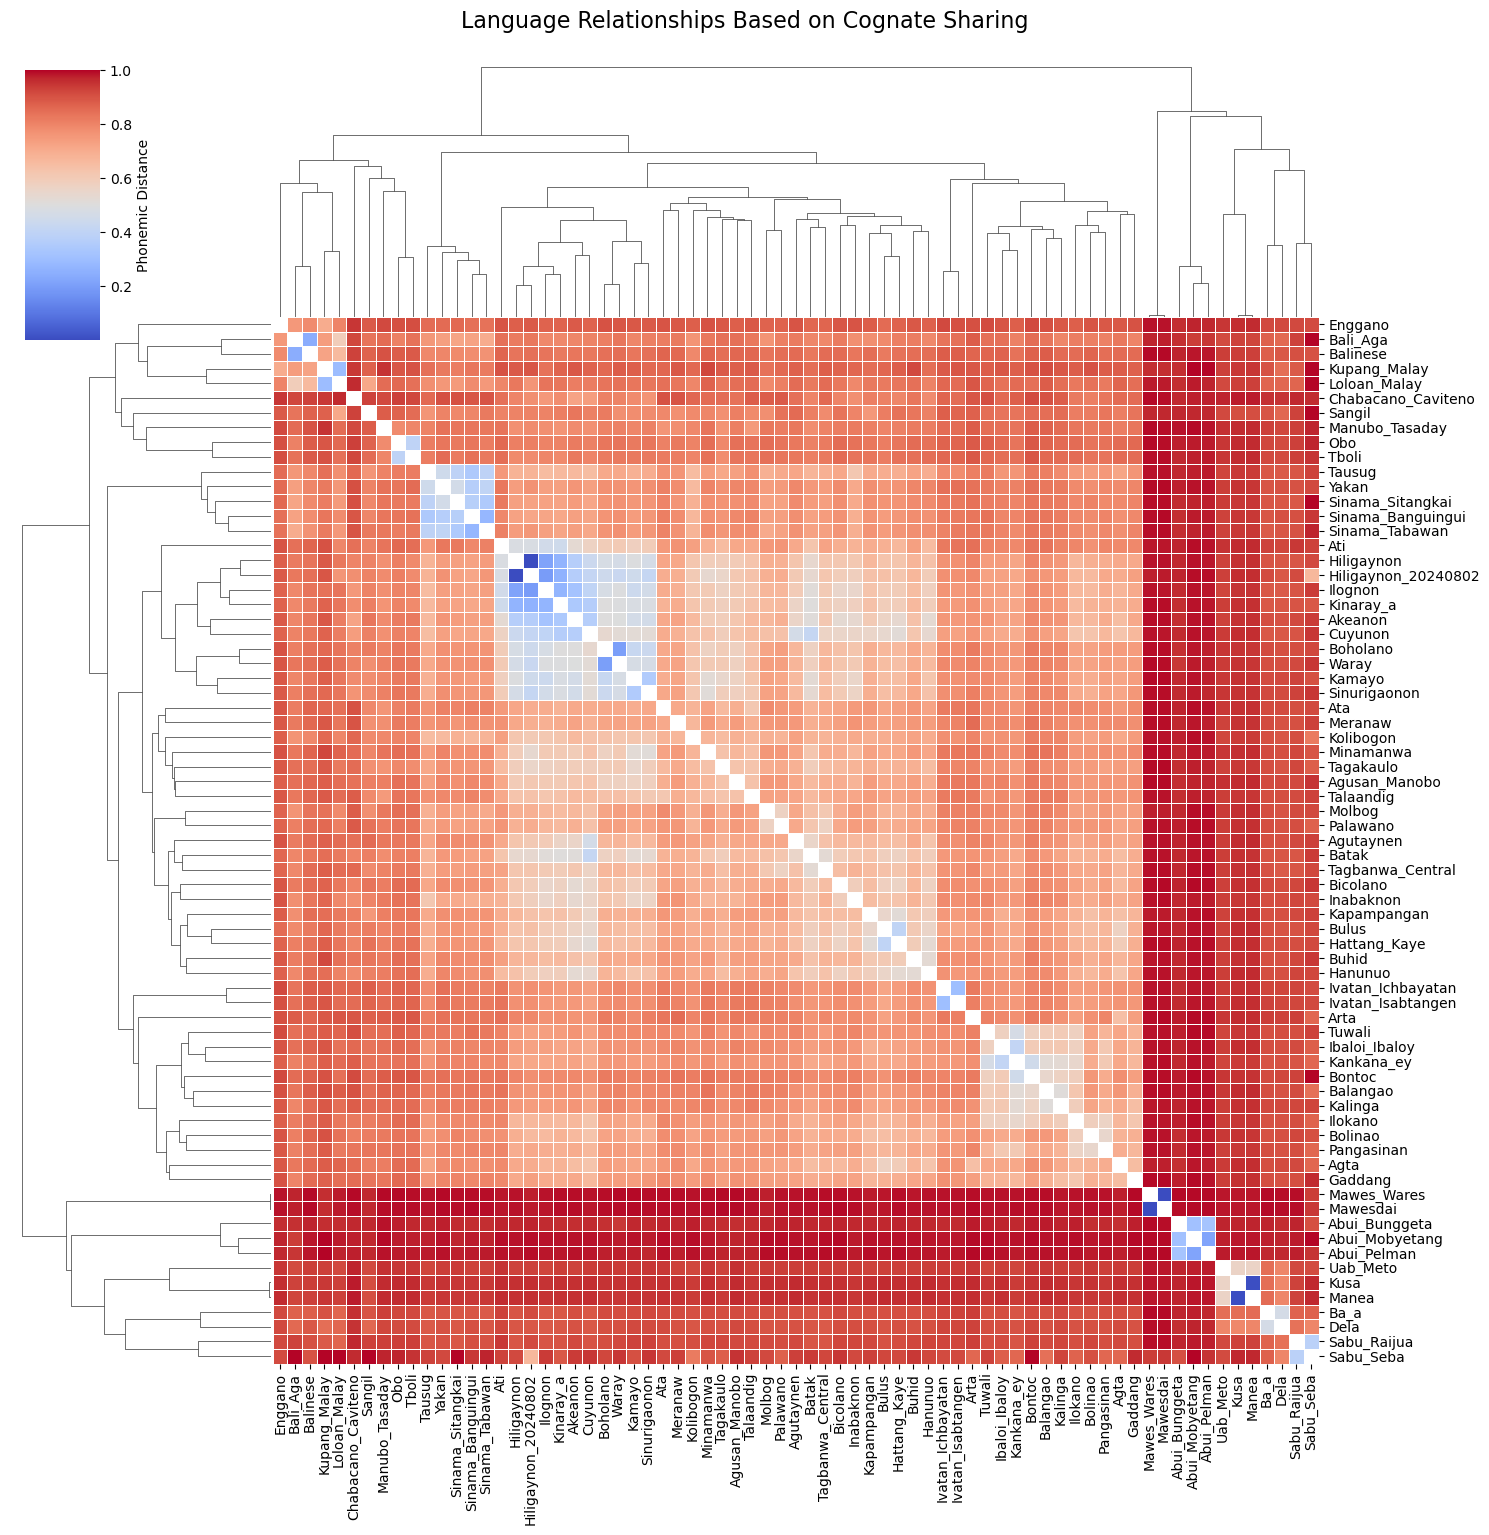

In [97]:
visualize_distance_matrix(dist_matrix=processed_distance_matrix)

In [98]:
def perform_pca_analysis(dist_matrix, pca_components=15):
    """Perform Principal Component Analysis on distance matrix."""
    print("\n" + "=" * 50)
    print("STEP 11: Principal Component Analysis")
    print("=" * 50)
    
    # Prepare data for PCA
    X = dist_matrix.values
    X_scaled = StandardScaler().fit_transform(X)
    
    # Perform PCA
    pca = PCA(n_components=pca_components)
    components = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_
    
    print(f"PCA completed with {pca_components} components")
    print(f"Total explained variance: {explained_variance.sum():.2%}")
    print(f"First component explain: {explained_variance[:1].sum():.2%}")
    print(f"First 2 components explain: {explained_variance[:2].sum():.2%}")
    print(f"First 3 components explain: {explained_variance[:3].sum():.2%}\n")
    
    # Plot explained variance (elbow plot)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, pca_components + 1), explained_variance, marker='o', linestyle='--')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Explained Variance (Elbow Plot)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\n")
    
    # Create PCA scatter plot (PC1 vs PC2)
    plt.figure(figsize=(12, 8))
    for i, lang in enumerate(dist_matrix.index):
        x, y = components[i, 0], components[i, 1]  # PC1 vs PC2
        plt.scatter(x, y, s=50, alpha=0.7)
        plt.annotate(lang, (x, y), xytext=(5, 5), textcoords='offset points', 
                    fontsize=8, ha='left')
    
    plt.title("PCA of Phonemic Distance Matrix (PC1 vs PC2)", fontsize=14)
    plt.xlabel(f"PC1 ({explained_variance[0]:.1%} variance)")
    plt.ylabel(f"PC2 ({explained_variance[1]:.1%} variance)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return pca, components


STEP 11: Principal Component Analysis
PCA completed with 15 components
Total explained variance: 82.94%
First component explain: 39.84%
First 2 components explain: 47.00%
First 3 components explain: 53.97%



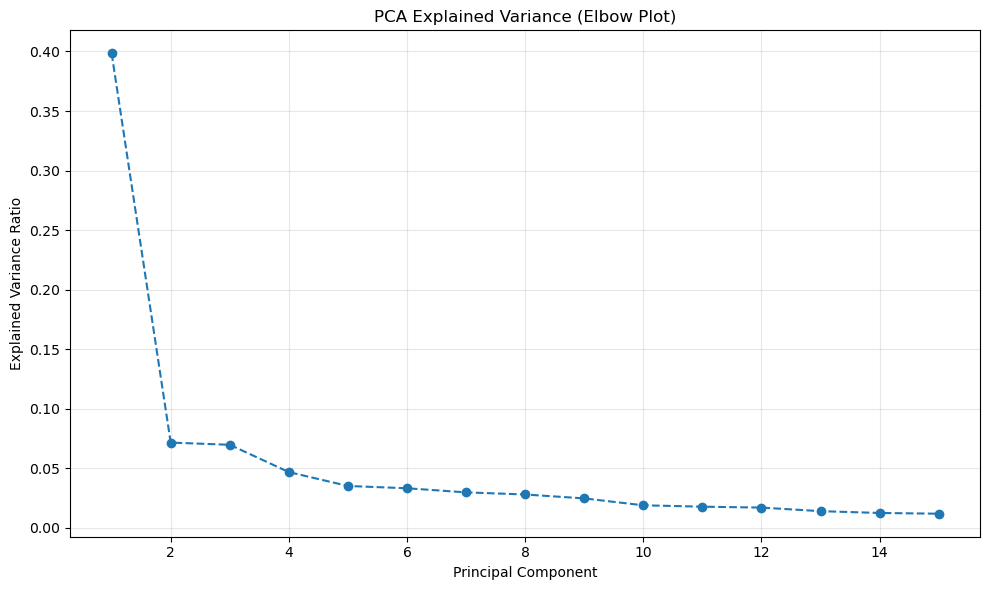

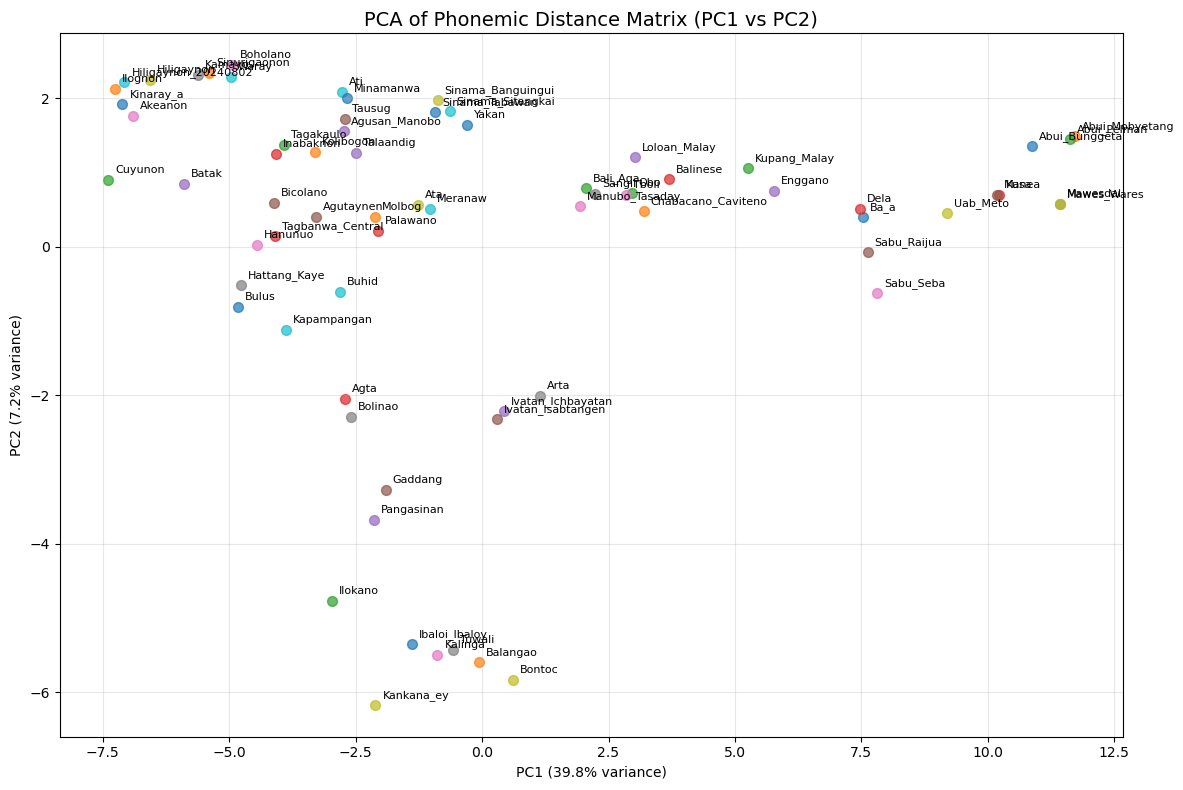

In [99]:
pca_results = perform_pca_analysis(dist_matrix=processed_distance_matrix, pca_components=15)

In [175]:
def create_geographic_map(initial_sheet_filename, save_map=True):
    """Create geographic map of languages."""
    print("\n" + "=" * 50)
    print("STEP 12: Creating geographic visualization")
    print("=" * 50)
    
    # Load geographic data
    try:
        geo_data = pd.read_excel(initial_sheet_filename)
        print(f"Loaded geographic data for {len(geo_data)} entries")
    except FileNotFoundError:
        print(f"Warning: {initial_sheet_filename} not found. Skipping geographic visualization.")
        return None
    
    # Filter for entries with coordinates
    languages_geo = geo_data[geo_data["latitude"].notnull()].copy()
    print(f"Found coordinates for {len(languages_geo)} languages")
    
    if len(languages_geo) == 0:
        print("No geographic coordinates found. Skipping map creation.")
        return None
    
    # Create GeoDataFrame
    languages_geo["geometry"] = languages_geo.apply(
        lambda row: Point(row["longitude"], row["latitude"]), axis=1
    )
    languages_gdf = gpd.GeoDataFrame(languages_geo, geometry="geometry", crs="EPSG:4326")
    
    # Prepare data for plotting
    languages_gdf["Latitude"] = languages_gdf["latitude"]
    languages_gdf["Longitude"] = languages_gdf["longitude"]
    languages_gdf["Language"] = languages_gdf.get("Language_BasedOnMasterSheet", 
                                                  languages_gdf.get("Language", "Unknown"))
    
    # Handle date line crossing (convert positive longitudes to negative for Pacific view)
    languages_gdf["Longitude_Pacific"] = [
        (x - 360 if x > 0 else x) for x in languages_gdf["Longitude"]
    ]
    
    # Create map
    fig = plt.figure(figsize=(16, 10))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    
    # Set extent for Pacific region
    ax.set_extent([70, 200, -30, 30], crs=ccrs.PlateCarree())
    
    # Add map features
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.7)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.5)
    
    # Plot language points
    for idx, row in languages_gdf.iterrows():
        ax.plot(row['Longitude'], row['Latitude'], 'o', 
               color='red', markersize=6, transform=ccrs.PlateCarree(), 
               markeredgecolor='darkred', markeredgewidth=1)
        ax.text(row['Longitude'] + 1, row['Latitude'] + 1, row['Language'], 
               fontsize=9, transform=ccrs.PlateCarree(), 
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))
    
    plt.title("Geographic Distribution of OCSEAN Languages", fontsize=16, pad=20)
    plt.show()
    
    # Save map
    if save_map:
        map_file = 'OCSEAN_languages_map.png'
        plt.savefig(map_file, dpi=300, bbox_inches='tight')
        print(f"Map saved to: {map_file}")
        
    return languages_gdf



STEP 12: Creating geographic visualization
Loaded geographic data for 71 entries
Found coordinates for 39 languages


2025-06-20 03:40:47,845 [WARNING] posx and posy should be finite values
2025-06-20 03:40:47,971 [WARNING] posx and posy should be finite values


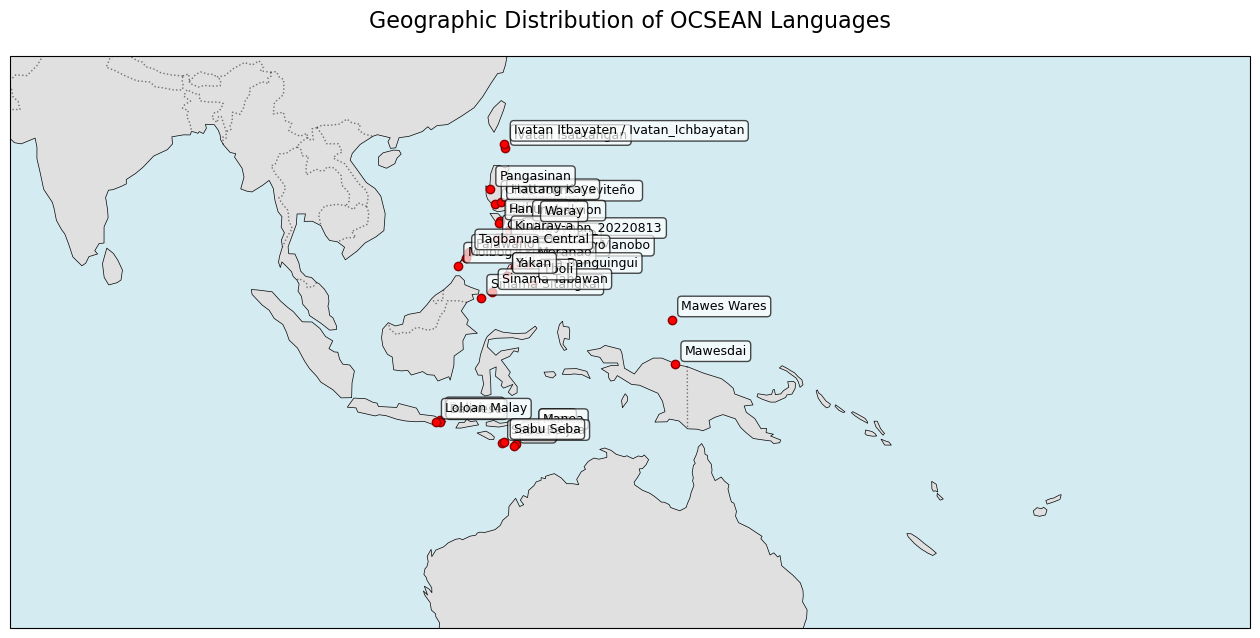

In [101]:
geo_map = create_geographic_map(initial_sheet_filename='OCSEAN_initial_englishsheet.xlsx', save_map=False)

In [102]:
def export_results_to_cldf(alignments):
    """Export results to CLDF format for interoperability."""
    print("\n" + "=" * 50)
    print("STEP 13: Exporting to CLDF format")
    print("=" * 50)
    
    try:
        cldf_path = 'ocsean-cldf-output'
        to_cldf(alignments, path=cldf_path)
        print(f"Results exported to CLDF format in: {cldf_path}/")
    except Exception as e:
        print(f"CLDF export encountered an issue: {e}")

In [103]:
export_results_to_cldf(alignments=OCSEAN_processed_alignments)


STEP 13: Exporting to CLDF format
Results exported to CLDF format in: ocsean-cldf-output/
